In this project we'll train agents that choose to run, pass, kick or punt based on the current yards to first, yards to goal, and down.

First we need to create a stable baselines3 compliant custom environment (SB3's guide - https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html).

In [1]:
import numpy as np
from numpy import random
from scipy import stats
import gym
from gym import spaces

# the function provides the other team's expected points when there is a change of possession.
def calc_ep(ydsToGo, ydsToGo_ep_intercept=5.211187389603027, ydsToGo_coef=-0.06155063):
    return ydsToGo_ep_intercept + ydsToGo * ydsToGo_coef

touchback_ep = calc_ep(80)

def normalize_continuous(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

class NflEnv(gym.Env):
    
    def __init__(self, init_yds_to_goal = 80):
        super(NflEnv, self).__init__()
        
        # Define action and observation space
        # They must be gym.spaces objects
        self.action_space = spaces.Discrete(4)  # 0 - run, 1 - pass, 2 - kick, 3 - punt

        
        self.observation_space = spaces.Dict({
            "yds_to_goal": spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
            "yds_to_first": spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
            "down": spaces.Discrete(4)
        })

        
        self.init_yds_to_goal = init_yds_to_goal
        self.init_down = 0
        self.init_yds_to_first = 10
        
        self.comp_percent=.642
        self.int_rate=.023
        self.sack_rate=.067
        self.sack_avg=-5
        self.sack_sd=1
        self.fmb_rate=.5 / (21.4 + 27.3)

    def step(self, action):
        
        prev_down = self.down
        prev_yds_to_first = self.yds_to_first
        prev_yds_to_goal = self.yds_to_goal
        
        self.down += 1
        score = 0
        # moved to instance attribute, delete if working
        # reward = 0
        yds = 0
        turnover = False

        # kick
        if action == 2:
            prob = random.rand()
            # made fg
            # https://www.reddit.com/r/nfl/comments/d4h2r0/kicker_accuracy_accounting_for_distance/
            if ((self.yds_to_goal < 60) & (self.yds_to_goal >= 50) & (prob <= .54)) \
                    | ((self.yds_to_goal < 50) & (self.yds_to_goal >= 40) & (prob <= .79)) \
                    | ((self.yds_to_goal < 40) & (self.yds_to_goal >= 30) & (prob <= .90)) \
                    | ((self.yds_to_goal < 30) & (prob <= .95)):
                yds = self.yds_to_goal
                self.yds_to_goal = 0
                self.yds_to_first = 0
                score = 3
                self.reward = score - touchback_ep
            # missed fg
            else:
                score = 0
                self.reward = score - calc_ep(100 - self.yds_to_goal)
            self.done = True
        # punt
        elif action == 3:  
            potential_yds = random.normal(loc=45, scale=5)
            if potential_yds >= self.yds_to_goal:
                touchback = (np.random.rand() < 0.1)
                if touchback:
                    yds = self.yds_to_goal - 20
                    self.yds_to_goal = 20
                else:
                    yds = self.yds_to_goal - 1
                    self.yds_to_goal = 1
            else:
                yds = potential_yds
                self.yds_to_goal = self.yds_to_goal - yds
    
            self.reward += ((yds / 100) - calc_ep(100 - self.yds_to_goal))
            self.done = True

        # run
        elif action == 0:
            yds = stats.lognorm.rvs(s=0.25558500132474415, loc=-15.189614313924665, scale=18.92331909863129, size=1)[0]
            # fumble?
            if np.random.rand() <= self.fmb_rate:
                turnover = True
        # pass
        elif action == 1:
            # sack?
            if np.random.rand() <= self.sack_rate:
                yds = random.normal(loc=self.sack_avg, scale=self.sack_sd)
                # fumble?
                if np.random.rand() <= self.fmb_rate:
                    turnover = True
            else:
                if self.yds_to_goal <= 20:
                    air_yds = \
                        stats.lognorm.rvs(s=0.18033921317690882, loc=-20.781271075327744, scale=27.083791999969066,
                                          size=1)[
                            0]
                else:
                    air_yds = \
                        stats.lognorm.rvs(s=0.3868256330626365, loc=-11.72666357691477, scale=21.714746429166233,
                                          size=1)[0]
                prob = np.random.rand()
                # completion?
                if prob <= self.comp_percent:
                    yds = air_yds
                    # fumble?
                    if np.random.rand() <= self.fmb_rate:
                        yds = air_yds
                        turnover = True
                # int?
                elif prob >= (1 - self.int_rate):
                    yds = air_yds
                    turnover = True
                # incomplete
                else:
                    yds = 0
        # if action is not kick or punt
        if action in [0, 1]:
            self.yds_to_goal = max(self.yds_to_goal - yds, 0)
            self.yds_to_first -= yds
            # first down?
            if self.yds_to_first <= 0:
                self.down = self.init_down
                self.yds_to_first = min(self.yds_to_goal, self.init_yds_to_first)
            # turnover on downs?
            elif self.down >= (self.init_down + 4):
                turnover = True
            # td?
            if self.yds_to_goal == 0:
                score = 7
                self.reward = score - touchback_ep
                self.done = True
            if turnover == True:
                score = 0
                # should take touchback into account
                self.reward = score - calc_ep(100 - self.yds_to_goal)
                self.done = True
            # trying a shaping reward here. just kind of winging this, probably needs refined
            self.reward += (yds / 100)
        
        # not sure this is right but I think 5th down (expressed as 4) is breaking things turnover, kick on fourth down 
        if (self.down == (self.init_down + 4)):
            self.down = self.init_down

        self.state = {
            "yds_to_goal": np.array([self.yds_to_goal], dtype=np.float32),
            "yds_to_first": np.array([self.yds_to_first], dtype=np.float32),
            "down": self.down  # Represents value 3 (0: 1st down, 1: 2nd down, 2: 3rd down, 3: 4th down)
        }
        
        self.episode_reward += self.reward
        
        info = {}
        info.update({
            'prev_down': prev_down,
            'prev_yds_to_first': prev_yds_to_first,
            'prev_yds_to_goal': prev_yds_to_goal,
            'yds': yds,
            'turnover': turnover,
            'score': score
        })
        
        
        return self.state, self.reward, self.done, info

    def reset(self, yds_to_goal=None):
        self.down = self.init_down
        self.yds_to_first = self.init_yds_to_first
        if yds_to_goal is not None:
            self.yds_to_goal = yds_to_goal
        else:
            self.yds_to_goal = self.init_yds_to_goal
        
        self.state = {
            "yds_to_goal": self.yds_to_goal
            , "yds_to_first": self.yds_to_first
            , "down": self.down}
        
        self.reward = 0
        self.episode_reward = 0
        self.done = False
        
        return self.state
    
    def set_yds_to_goal(self, yds_to_goal):
        self.yds_to_goal = yds_to_goal
        self.state = {
            "yds_to_goal": self.yds_to_goal
            , "yds_to_first": self.yds_to_first
            , "down": self.down}
        
        return self.state
        
    
    def pretty_print(self, state, action, info):
        down = state["down"]
        yds_to_first = state["yds_to_first"][0]
        yds_to_goal = state["yds_to_goal"][0]
        
        yds = info["yds"]
        turnover = info["turnover"]
        score = info["score"]
        prev_down = info["prev_down"]
        prev_yds_to_first = info["prev_yds_to_first"]
        prev_yds_to_goal = info["prev_yds_to_goal"]

        if action == 0:
            action = "Run"
        elif action == 1:
            action = "Pass"
        elif action == 2:
            action = "Kick"
        elif action == 3:
            action = "Punt"
        
        print(f"Down: {prev_down}, Yards to First: {prev_yds_to_first:.1f}, Yards to Goal: {prev_yds_to_goal:.1f}, Action: {action}, Yards Gained: {yds:.1f}, Turnover: {turnover}")
        if turnover: print('Turnover')
        if action == 'Kick':
            if score == 3:
                print('Made Field Goal')
            else:
                print('Missed Field Goal')
        if score == 7: print('Touchdown')
            
        return

Before we train the agents let's first try a custom policy on the environment. We'll use this as a benchmark to see how well the agents learn. Further, let's create two styles (chill & agro) so we can watch them play against each other. We'll want that functionality when we have the agents.

In [2]:
from random import choices

def custom_policy(state, style = 'chill'):
    down = state['down']
    yds_to_first = state['yds_to_first']
    yds_to_goal = state['yds_to_goal']

    if down == 0:
        if style == 'chill':
            # run first team
            return choices([0, 1], weights=[70, 30], k=1)[0]
        elif style == 'agro':
            # pass first team
            return choices([0, 1], weights=[30, 70], k=1)[0]
        
    if down == 1:
        # heavy run first if ahead of the sticks
        if yds_to_first <= (2*10/3):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # else pass first
        else:
            return choices([0, 1], weights=[30, 70], k=1)[0]
        
    if down == 2:
        # passing down if well behind the sticks
        if yds_to_first >= (2*10/3):
            return 1
        # heavy run first if ahead of the sticks
        elif yds_to_first <= (10/3):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # else (>3.33 and <6.67) pass first
        else:
            return choices([0, 1], weights=[30, 70], k=1)[0]

    # Kick on fourth down if yards to goal is less than 60 yards else same logic as third down
    if down == 3:
        # agro will always go for it ahead of the sticks
        if (style == 'agro') & (yds_to_first <= (10/3)):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # kick
        elif yds_to_goal < 60:
            return 2
        # punt
        else:
            return 3

def custom_policy(state, style = 'chill'):
    down = state['down']
    yds_to_first = state['yds_to_first']
    yds_to_goal = state['yds_to_goal']

    if down == 0:
        if style == 'chill':
            # run first team
            return choices([0, 1], weights=[70, 30], k=1)[0]
        elif style == 'agro':
            # pass first team
            return choices([0, 1], weights=[30, 70], k=1)[0]
        
    if down == 1:
        # heavy run first if ahead of the sticks
        if yds_to_first <= (2*10/3):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # else pass first
        else:
            return choices([0, 1], weights=[30, 70], k=1)[0]
        
    if down == 2:
        # passing down if well behind the sticks
        if yds_to_first >= (2*10/3):
            return 1
        # heavy run first if ahead of the sticks
        elif yds_to_first <= (10/3):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # else (>3.33 and <6.67) pass first
        else:
            return choices([0, 1], weights=[30, 70], k=1)[0]

    # Kick on fourth down if yards to goal is less than 60 yards else same logic as third down
    if down == 3:
        # agro will always go for it ahead of the sticks
        if (style == 'agro') & (yds_to_first <= (10/3)):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # kick
        elif yds_to_goal < 60:
            return 2
        # punt
        else:
            return 3


def evaluate_custom_policy(env, style='chill', n_episodes=1000, watch=False):
    rewards = []
    
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        step_count = 0

        while not done:
            action = custom_policy(state)
            state, reward, done, info = env.step(np.array([action]))
            episode_reward += reward

            if watch and episode == n_episodes - 1:
                yds = info['yds']
                prev_down = info['prev_down']
                prev_yds_to_first = info['prev_yds_to_first']
                prev_yds_to_goal = info['prev_yds_to_goal']
                turnover = info['turnover']
                print(f"Step: {step_count}, Dwn: {prev_down}, to First: {round(float(prev_yds_to_first), 2)}, to Goal: {round(float(prev_yds_to_goal), 2)}, Action: {action}, Yds Gained: {round(float(yds), 2)}, Reward: {round(float(reward), 2)}, Tot Reward: {round(float(episode_reward), 2)}, TO: {turnover}")

            step_count += 1
        
        rewards.append(episode_reward)

    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    return mean_reward, std_reward

n_eval_episodes = 1_000
styles = ['chill', 'agro']
for style in styles:
    env = NflEnv()
    mean_reward_custom, std_reward_custom = evaluate_custom_policy(env, style, n_episodes=n_eval_episodes, watch=False)
    print(f"{style} Custom policy mean reward: {mean_reward_custom:.2f} +/- {std_reward_custom:.2f}")

chill Custom policy mean reward: 2.83 +/- 4.15
agro Custom policy mean reward: 2.85 +/- 4.27


Let's watch the two styles play a game against each other, first with text and then with images.

In [3]:
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

def draw_field(player_with_ball, starting_yds_to_goal, yds, drive_yds, player_1_score, player_2_score, one_image='n'):
    plt.figure(figsize=(20, 5))
    plt.barh(0, 100, color='green', height=5)
    plt.xlim(0, 100)
    plt.ylim(-1, 1)
    plt.xticks(range(0, 101, 10))
    plt.yticks([])
    plt.grid(axis='x')

    if player_with_ball == 1:
        starting_ball_position = (100 - starting_yds_to_goal)
        ball_position = starting_ball_position + drive_yds
    elif player_with_ball == 2:
        starting_ball_position = starting_yds_to_goal
        ball_position = starting_ball_position - drive_yds
    
    # Plot the ball
    plt.plot(ball_position, 0, 'o', markersize=20, color='orange')

    plt.text(ball_position, 0.1, f'Play gain: {yds} yards\nTotal drive: {drive_yds} yards',
             horizontalalignment='center', verticalalignment='bottom', color='white', fontsize=12, fontweight='bold')

    if player_with_ball == 1:
        plt.barh(0, drive_yds, left=starting_ball_position, color='red', height=0.1)
    else:  # team 2
        plt.barh(0, drive_yds, left=ball_position, color='blue', height=0.1)
    
    # Add a scoreboard in the top right corner
    plt.text(98, 0.8, f'Team 1: {player_1_score}\nTeam 2: {player_2_score}', 
             horizontalalignment='right', verticalalignment='top', 
             bbox=dict(boxstyle="square,pad=1", fc="white", ec="black"), fontsize=14)
    
    if one_image == 'n':
        plt.show()
    else:
        clear_output(wait=True)  # This will clear the output before showing the new plot
        display(plt.gcf())  # This will display the current plot
        plt.close()  # This will close the plot so it doesn't get shown again later
        time.sleep(0.5)  # wait for half second between plays
        


# def play_game(env, possessions=2, players = [1, 2], text_viz='y', image_viz='n', one_image='n'):
def play_game(env, possessions=2, style_1='chill', style_2='agro', model_1=None, model_2=None, players = [1, 2], text_viz='y', image_viz='n', one_image='n'):
    
    starting_yds_to_goal = 80
    player_1_score = 0
    player_2_score = 0
    
    if model_1 is not None:
        print('player 1 is an agent')
    else:
        print(f'player 1 is using {style_1} play style')
    if model_2 is not None:
        print('player 2 is an agent')
    else:
        print(f'player 2 is using {style_2} play style')
    print()

    for possessions in range(1, possessions+1):

        for player in players:
            
            if text_viz == 'y':
                if player == 1:
                    print(f"player 1 taking possession with {starting_yds_to_goal:.2f} yards to go")
                else:
                    print(f"player 2 taking possession with {starting_yds_to_goal:.2f} yards to go")
            
            state = env.reset(yds_to_goal = starting_yds_to_goal)
            
            done = False
            episode_reward = 0
            
            drive_yds = 0

            while not done:
                state_array = {'yds_to_goal': np.array([state['yds_to_goal']]), 'yds_to_first': np.array([state['yds_to_first']]), 'down': np.array([state['down']])}
                if player == 1:
                    if model_1 is not None:
                        action, _states = model_1.predict(state_array)
                    else:
                        action = custom_policy(state, style=style_1)
                elif player == 2:
                    if model_2 is not None:
                        action, _states = model_2.predict(state_array)
                    else:
                        action = custom_policy(state, style=style_2)
                state, reward, done, info = env.step(np.array([action]))
                episode_reward += reward
                
                score = info["score"]                
                if player == 1:
                    player_1_score += score
                else:
                    player_2_score += score
                
                if text_viz == 'y':
                    env.pretty_print(state, action, info)
                    
                if image_viz == 'y':
                    yds = info["yds"]
                    drive_yds += yds
                    draw_field(player_with_ball=player, starting_yds_to_goal=round(starting_yds_to_goal,1), yds=round(yds,1), drive_yds=round(drive_yds,1), player_1_score=player_1_score, player_2_score=player_2_score, one_image=one_image)
                                
            # if not made fg or td, probably better way to implement. This doesn't include punt touchbacks.
            if score < 3:
                starting_yds_to_goal = 100 - state["yds_to_goal"][0]
            else:
                starting_yds_to_goal = 80
            
            if text_viz == 'y':
                print('Scoreboard:')
                print(f"player 1 - {player_1_score}")
                print(f"player 2 - {player_2_score}")
                print()

In [4]:
play_game(env=NflEnv())

player 1 is using chill play style
player 2 is using agro play style

player 1 taking possession with 80.00 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Pass, Yards Gained: 22.3, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 57.7, Action: Pass, Yards Gained: -3.1, Turnover: False
Down: 1, Yards to First: 13.1, Yards to Goal: 60.9, Action: Pass, Yards Gained: 0.0, Turnover: False
Down: 2, Yards to First: 13.1, Yards to Goal: 60.9, Action: Pass, Yards Gained: 7.0, Turnover: False
Down: 3, Yards to First: 6.2, Yards to Goal: 53.9, Action: Kick, Yards Gained: 53.9, Turnover: False
Made Field Goal
Scoreboard:
player 1 - 3
player 2 - 0

player 2 taking possession with 80.00 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Pass, Yards Gained: 0.0, Turnover: False
Down: 1, Yards to First: 10.0, Yards to Goal: 80.0, Action: Pass, Yards Gained: 5.1, Turnover: False
Down: 2, Yards to First: 4.9, Yards to Goal: 74.9, Action: Run, Ya

player 1 is using chill play style
player 2 is using agro play style



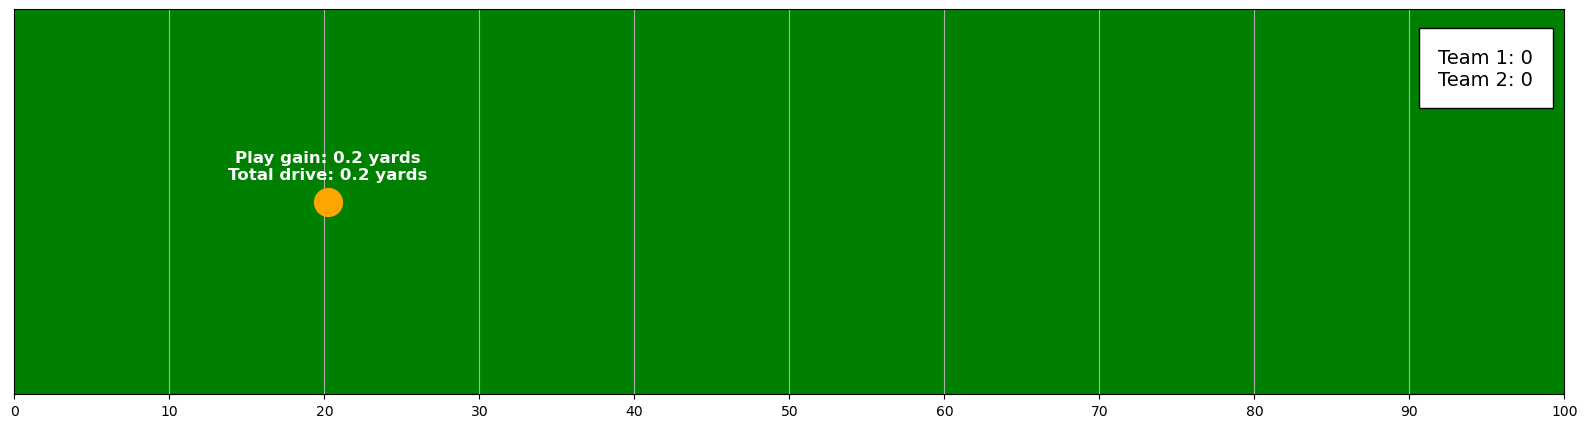

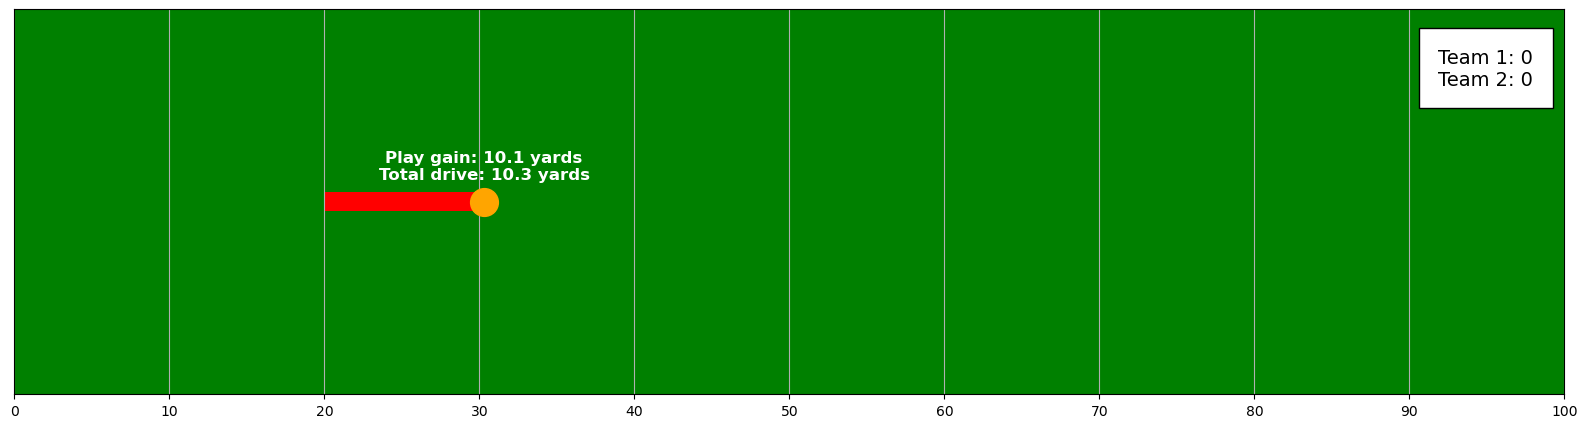

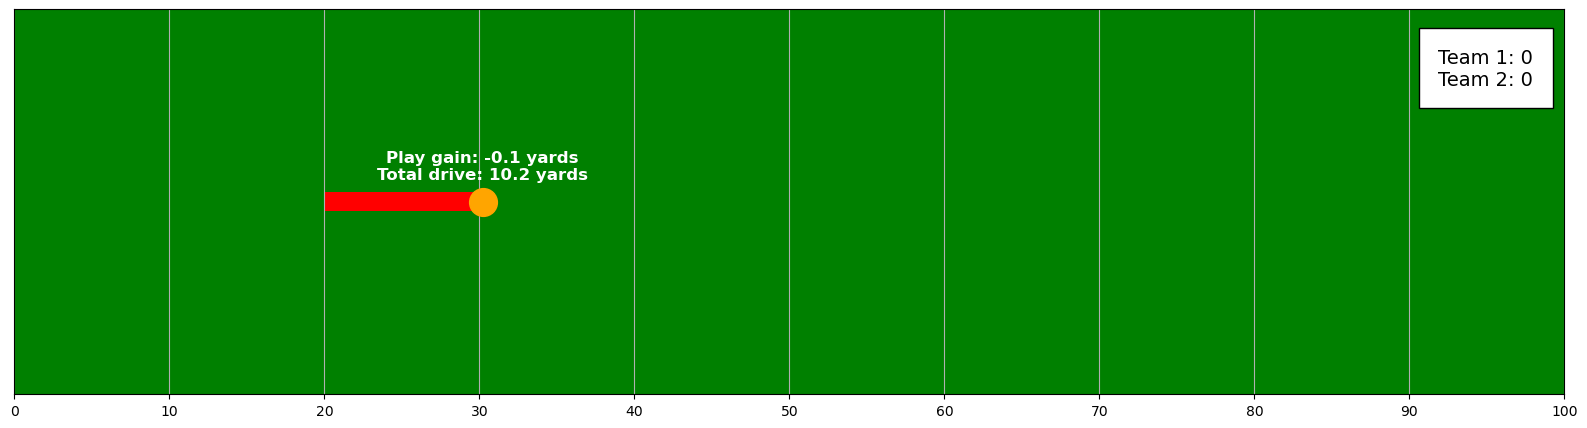

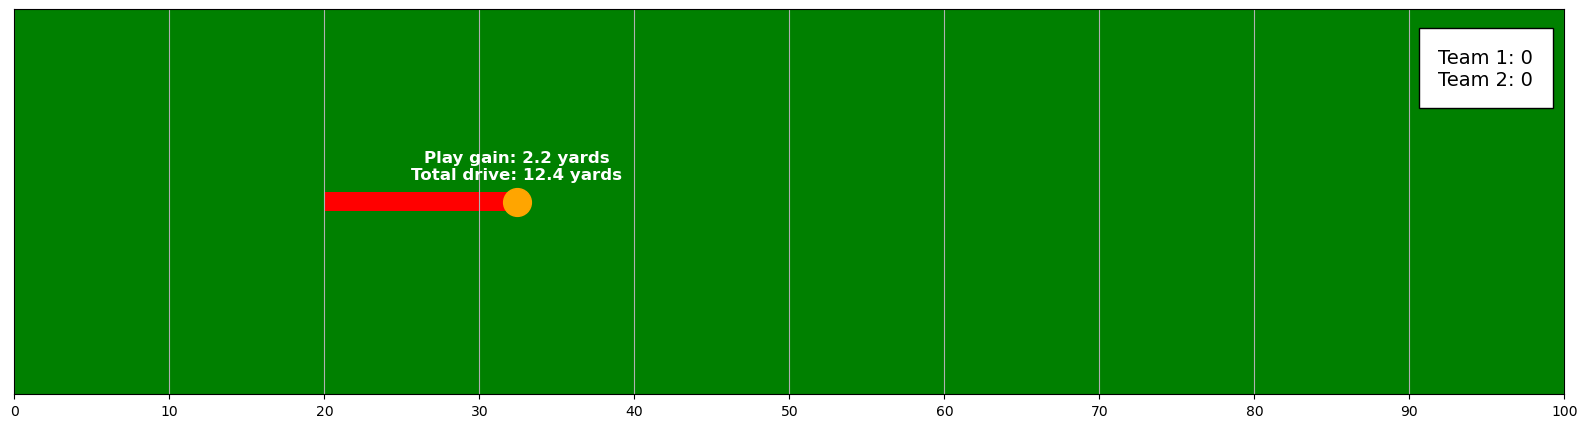

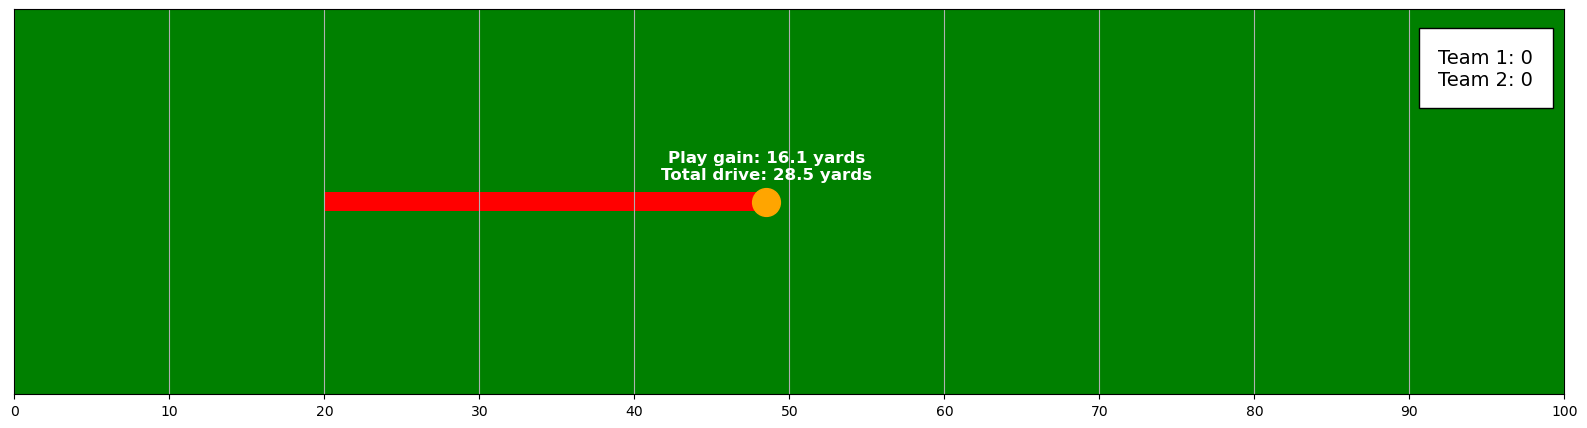

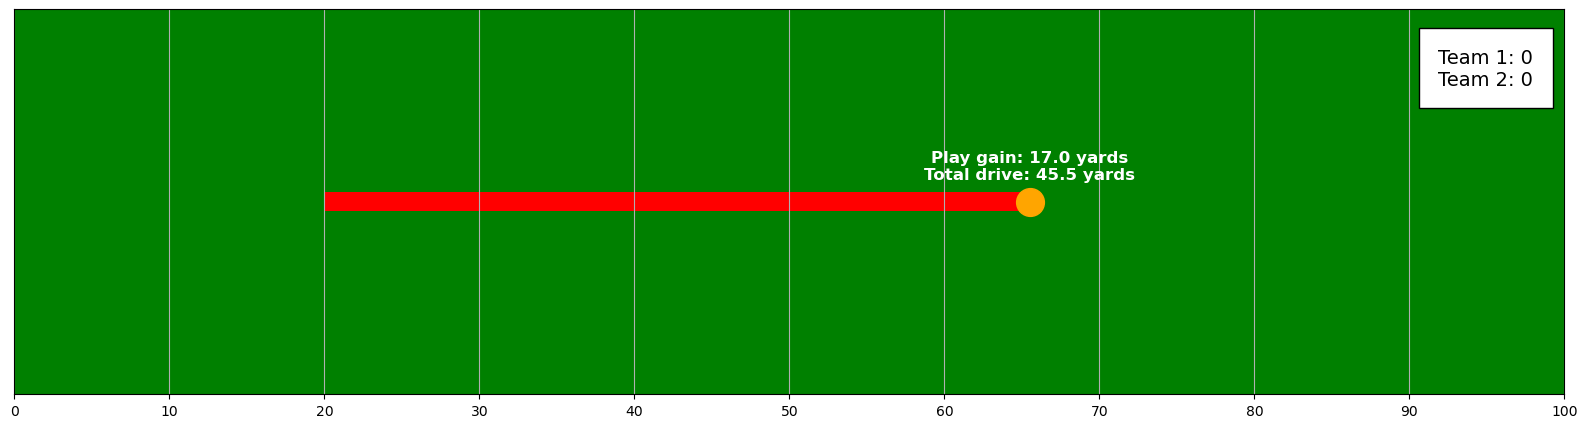

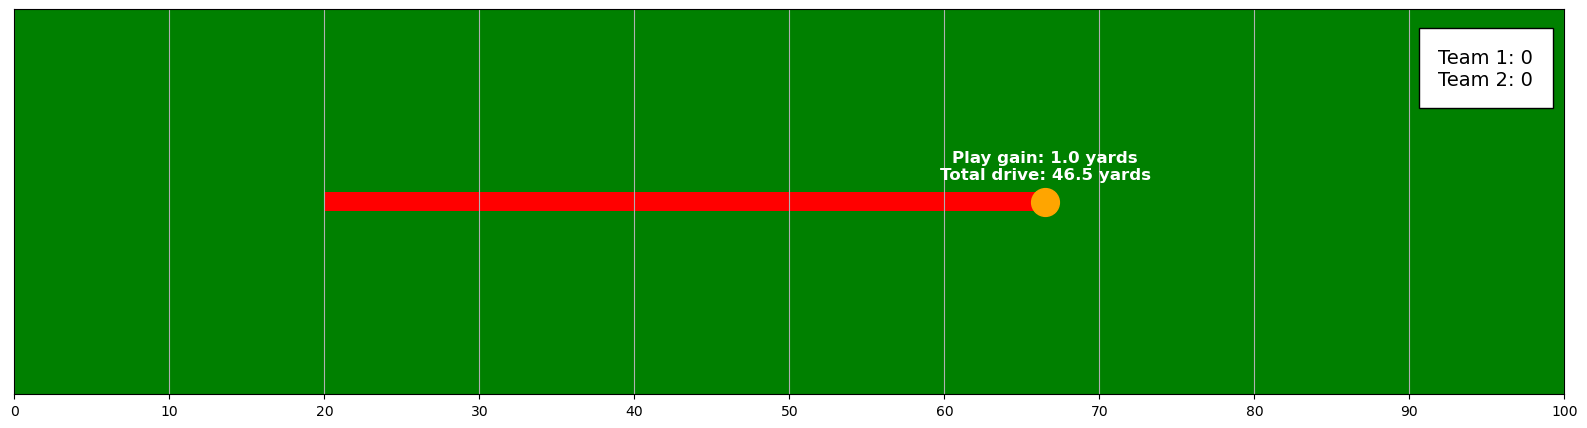

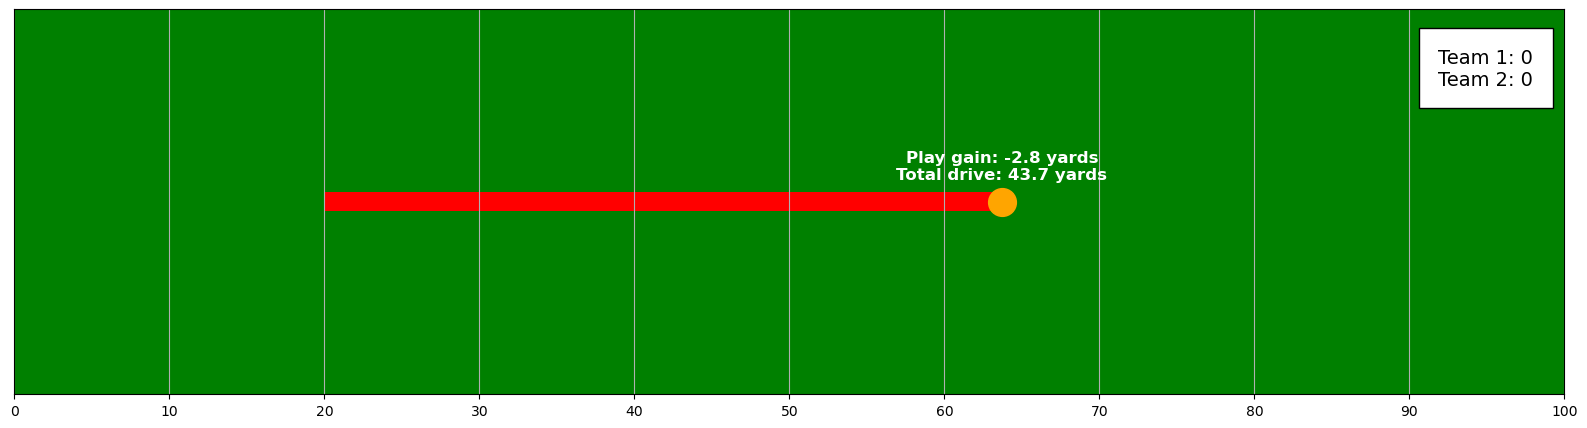

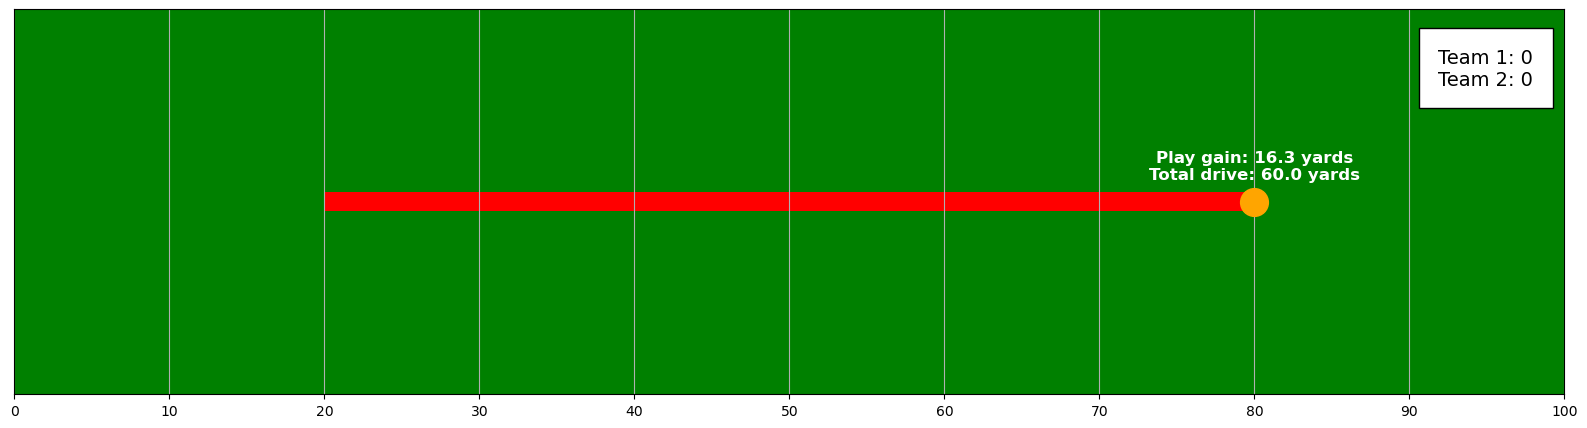

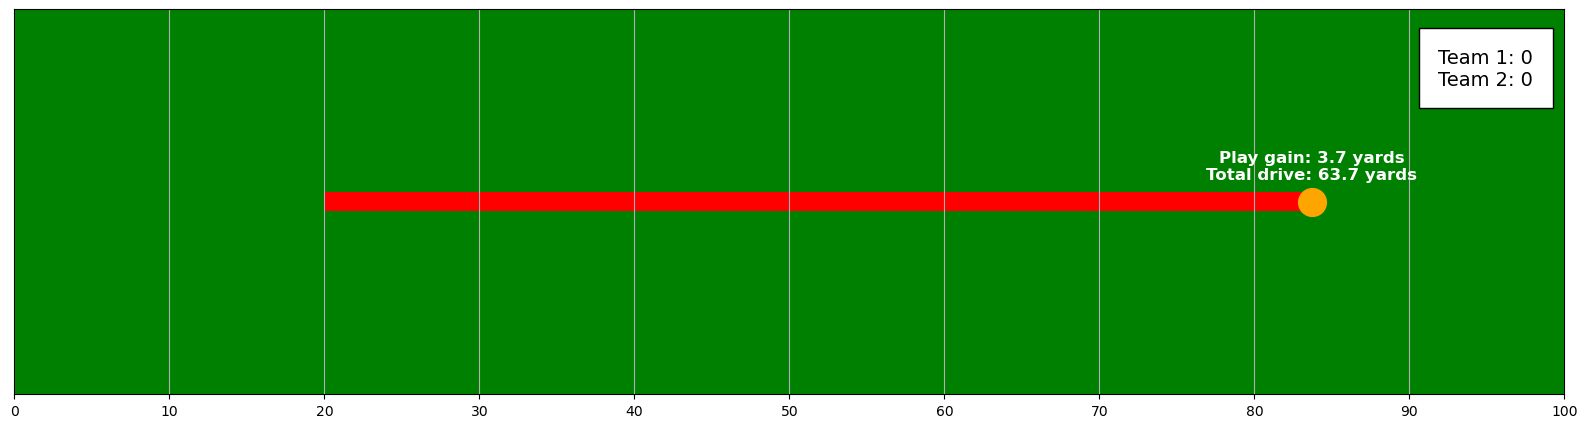

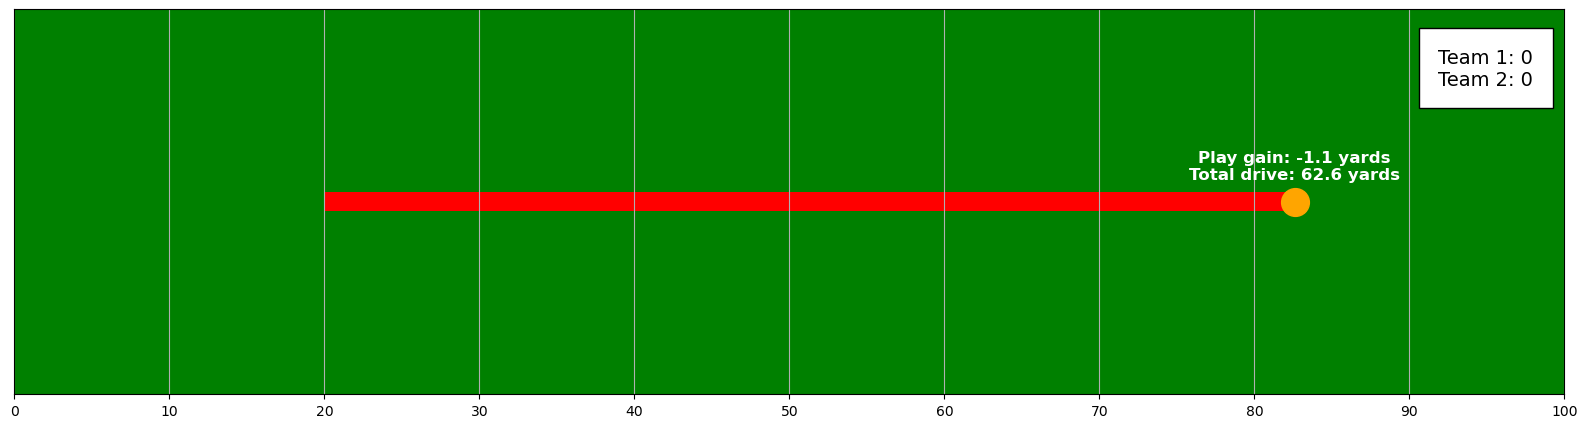

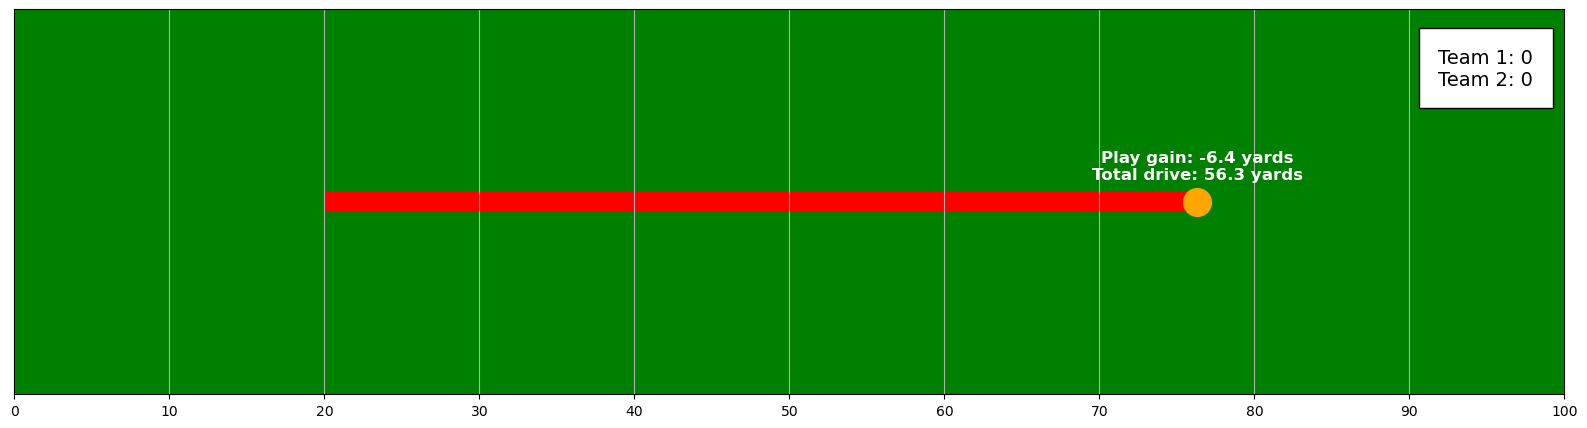

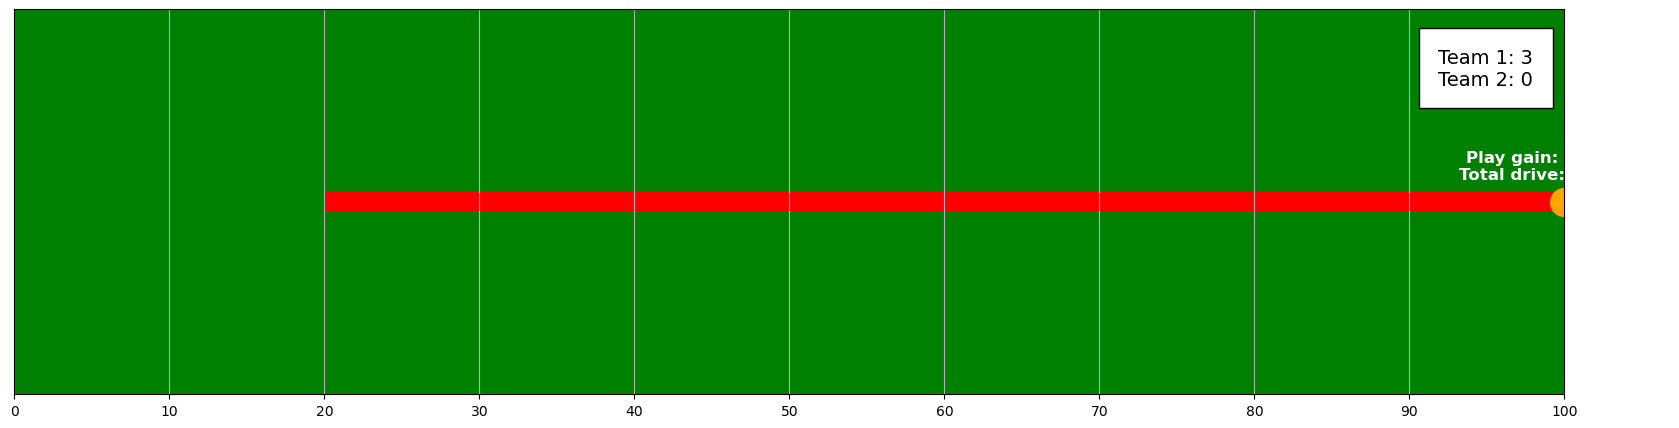

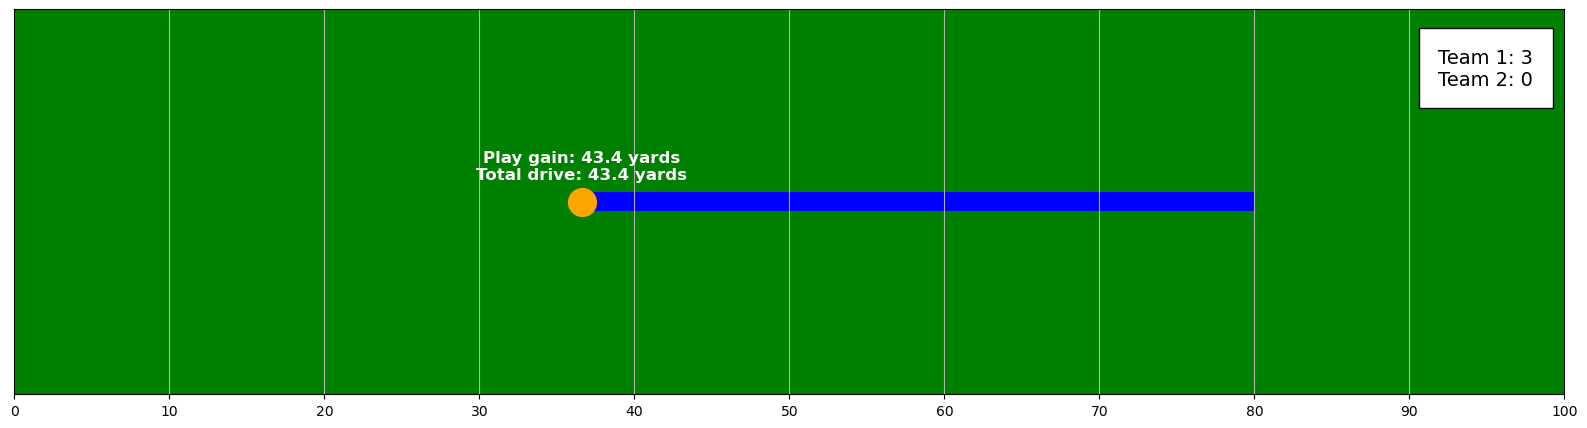

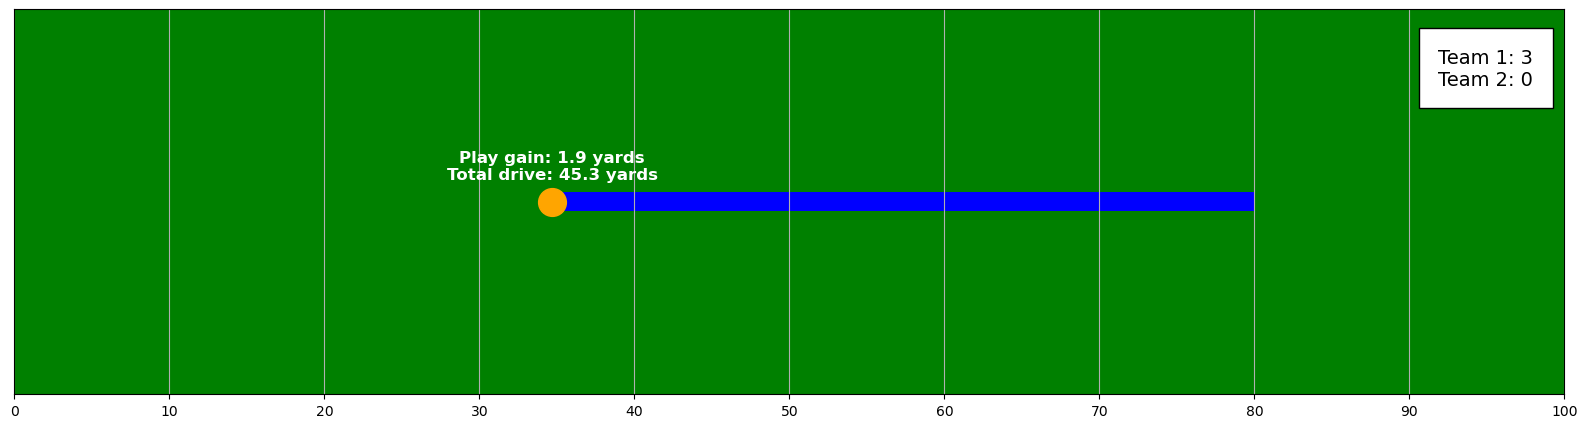

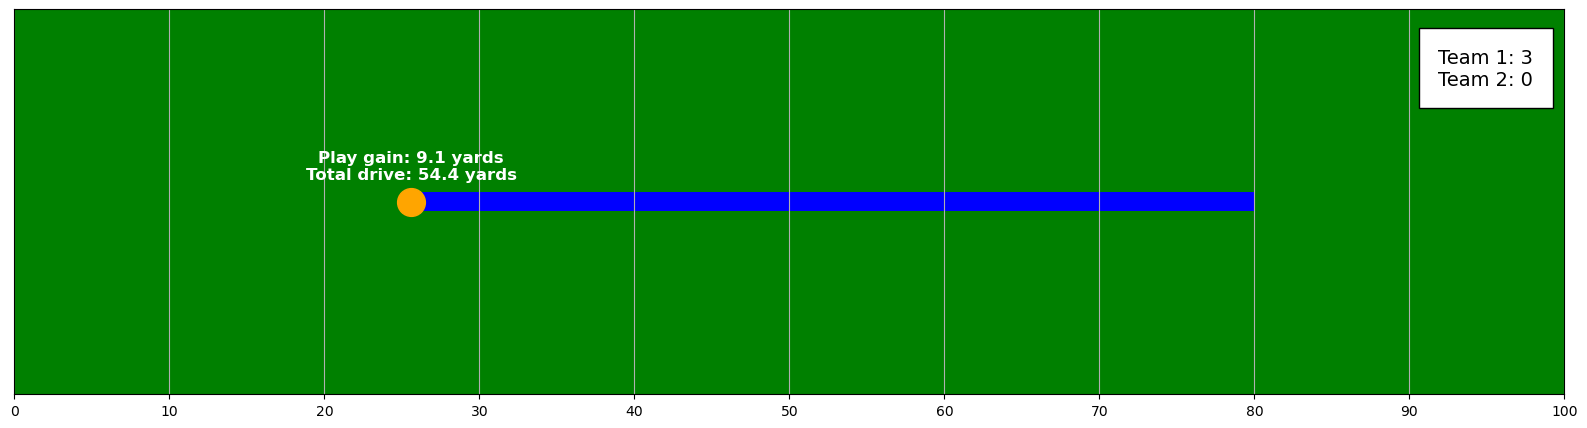

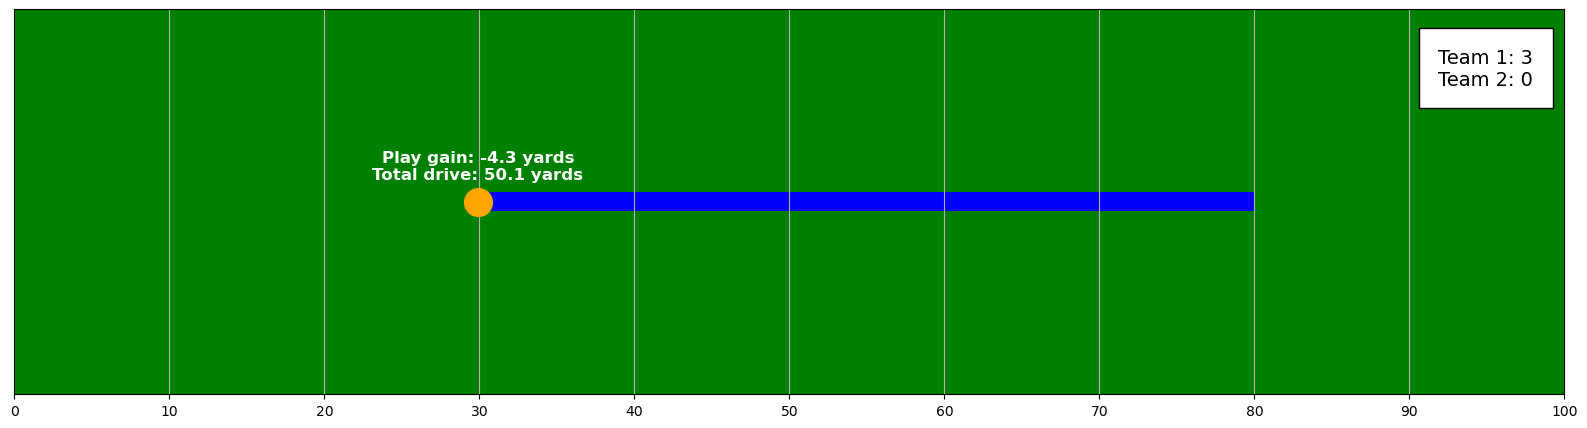

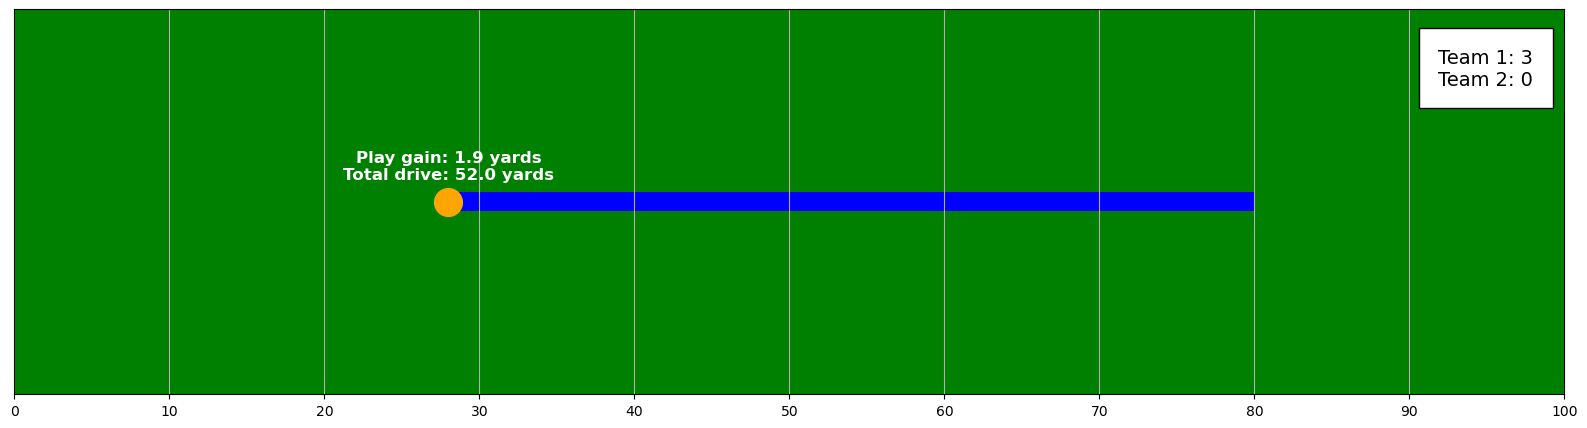

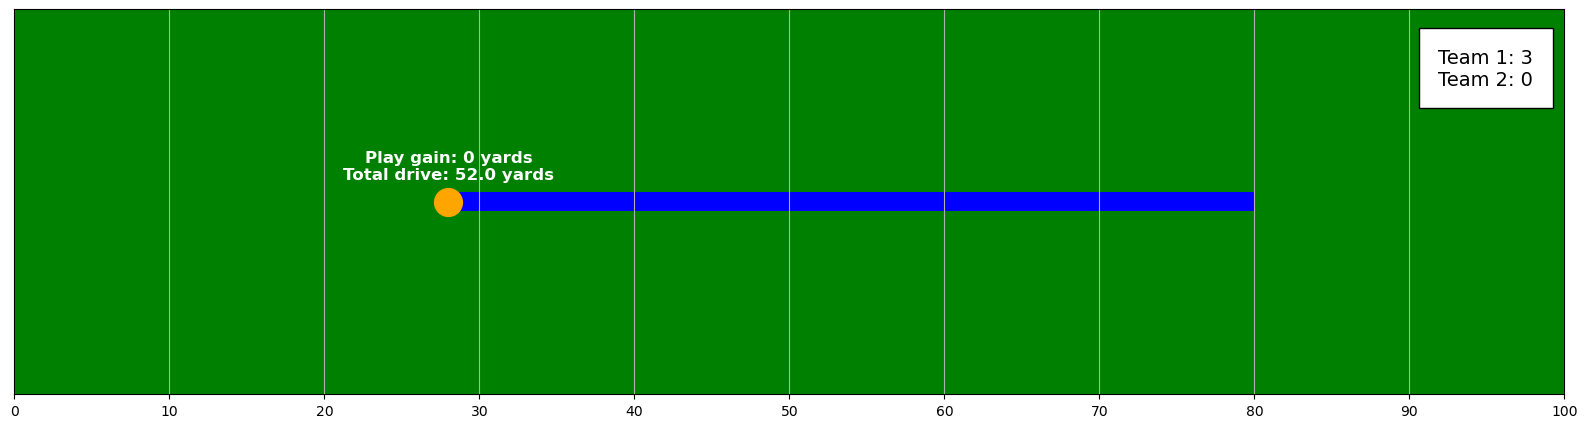

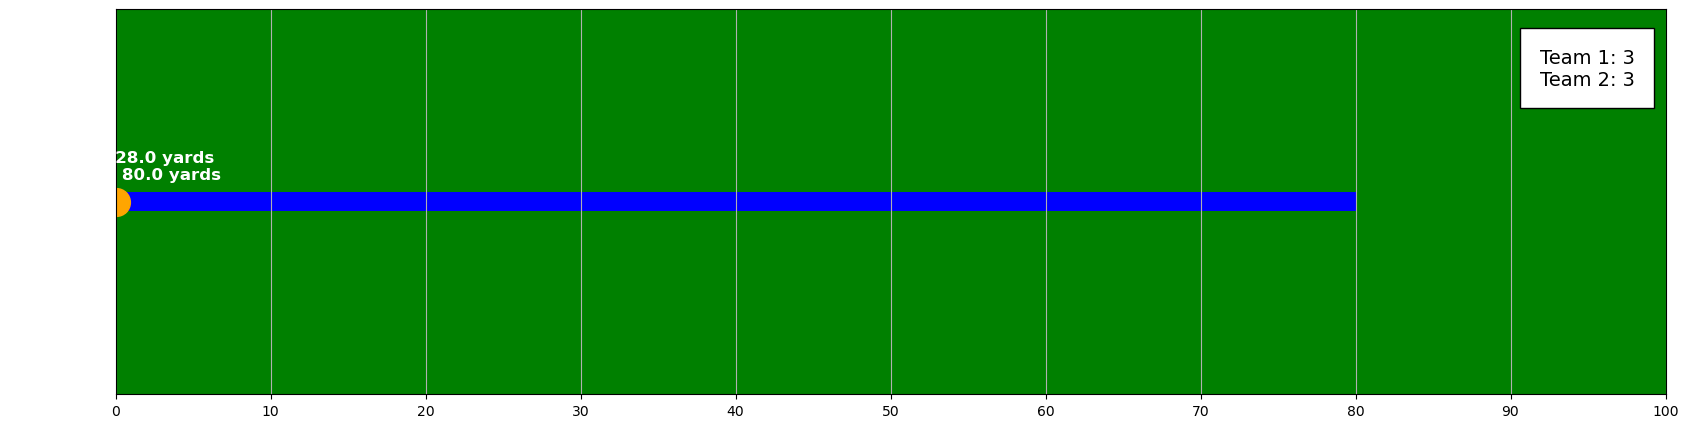

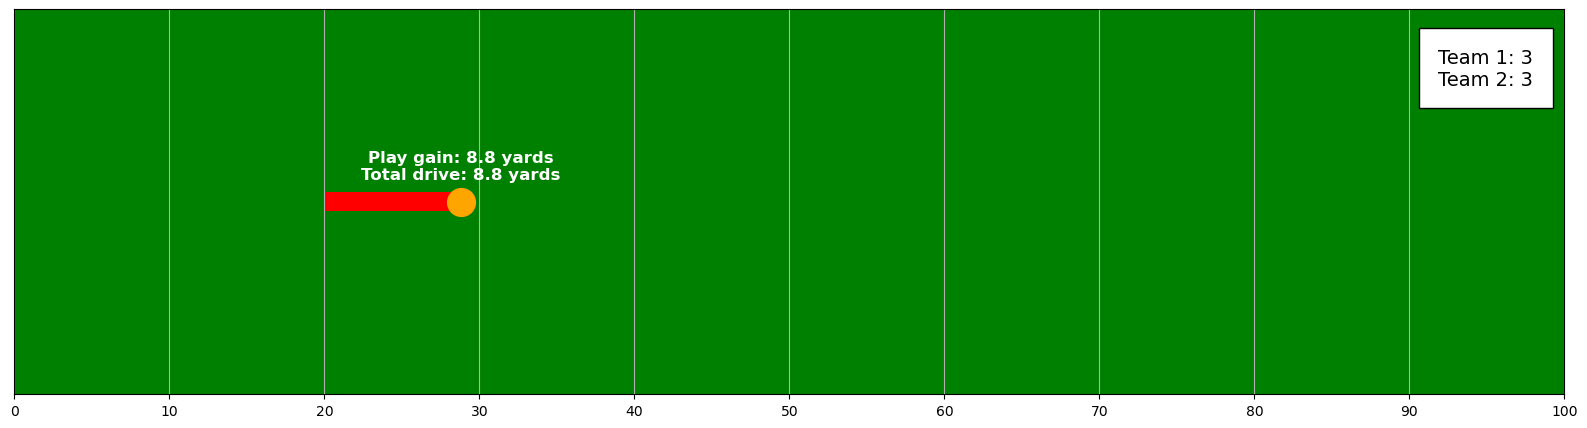

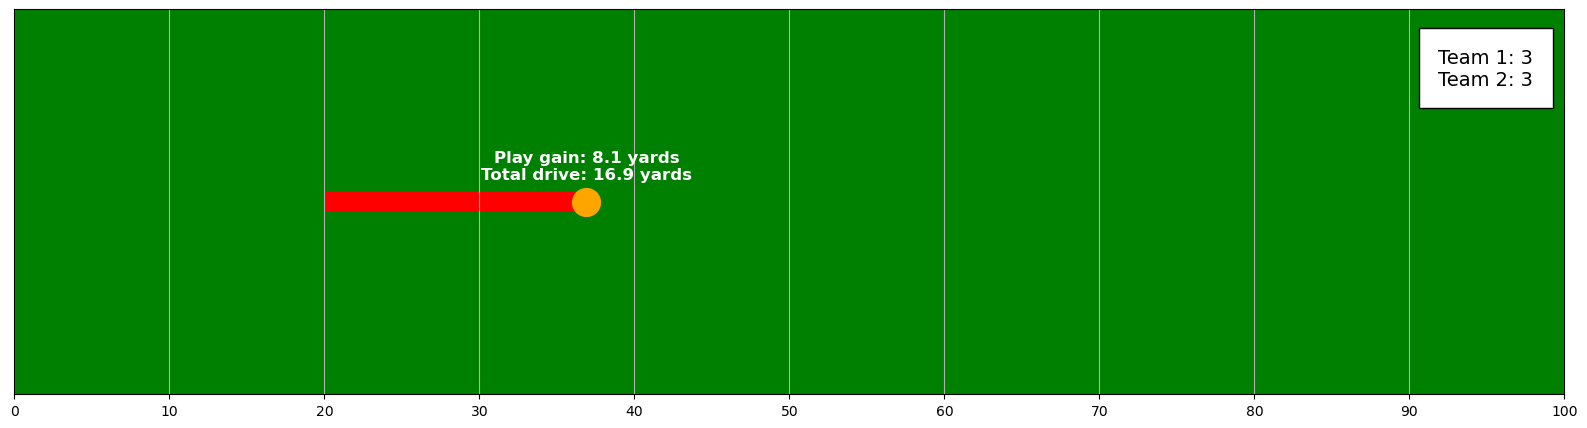

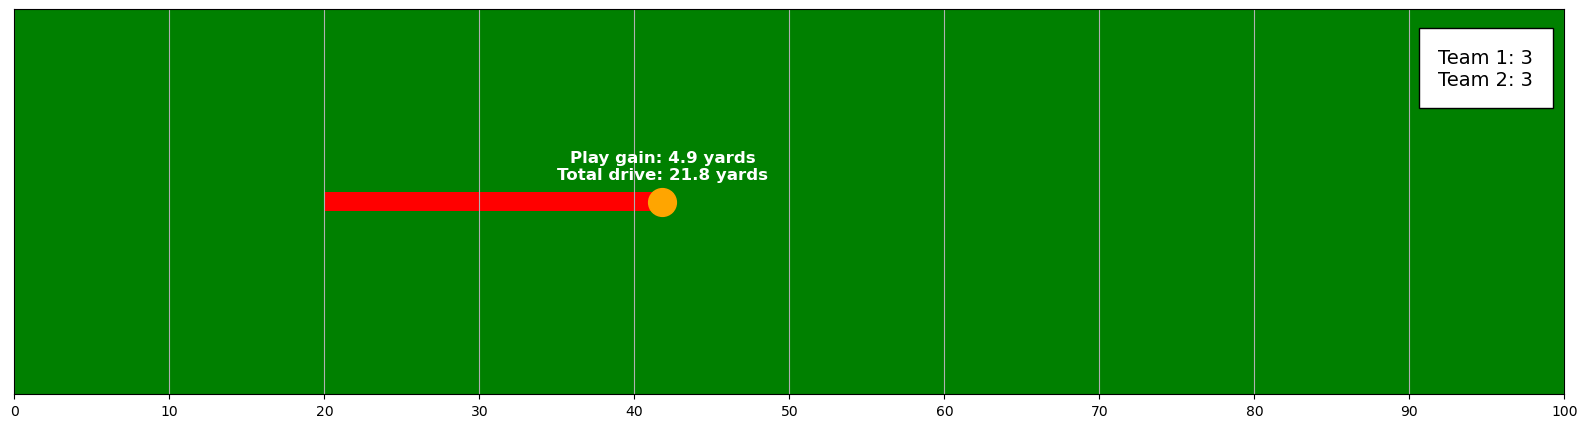

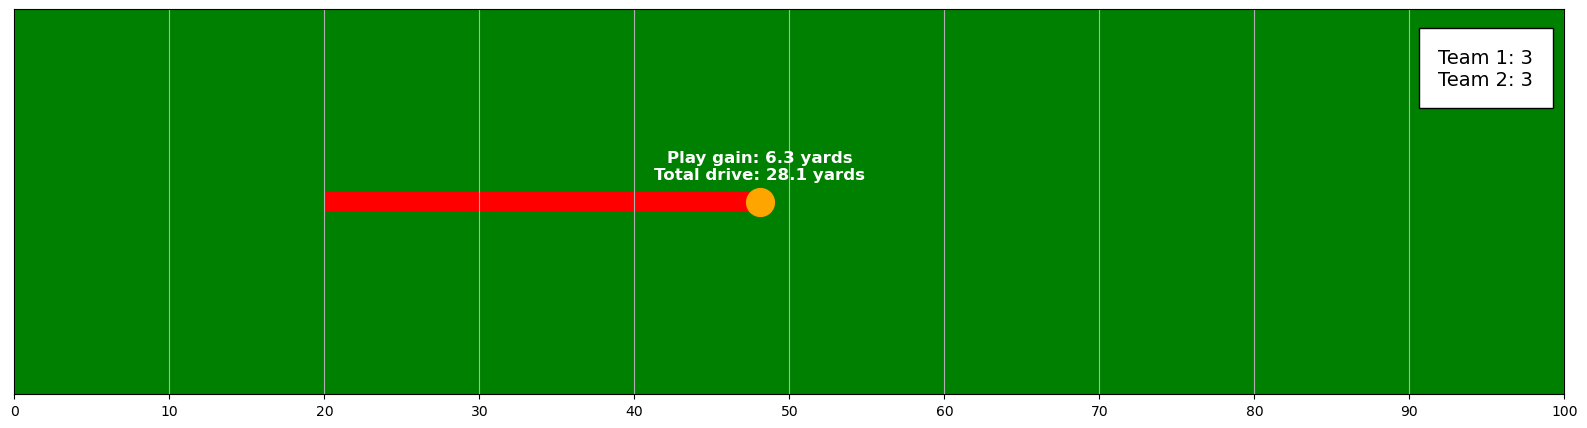

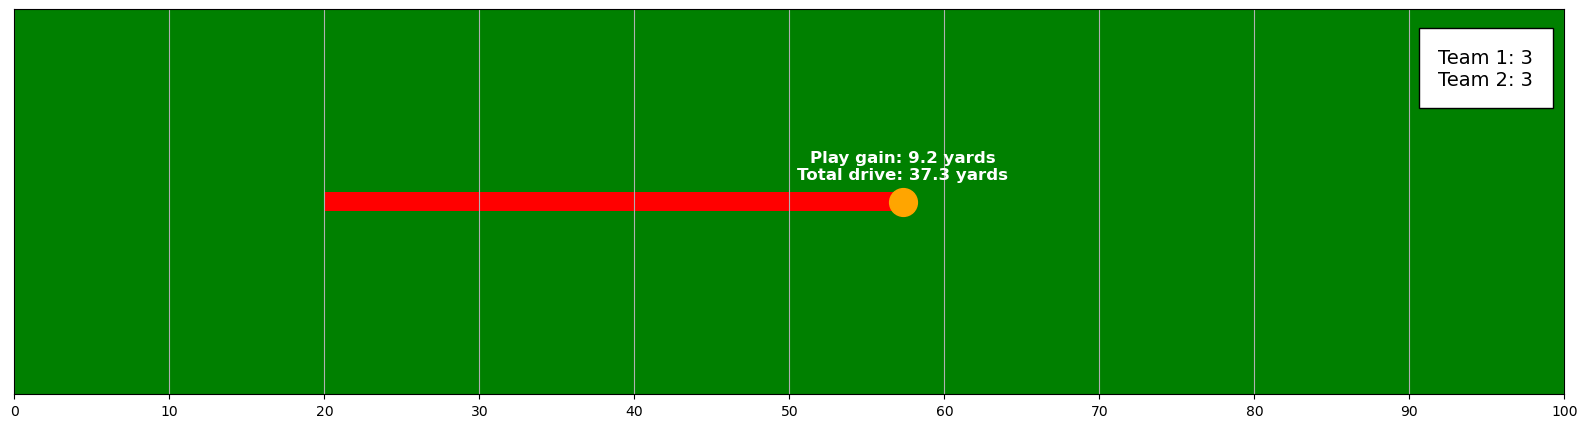

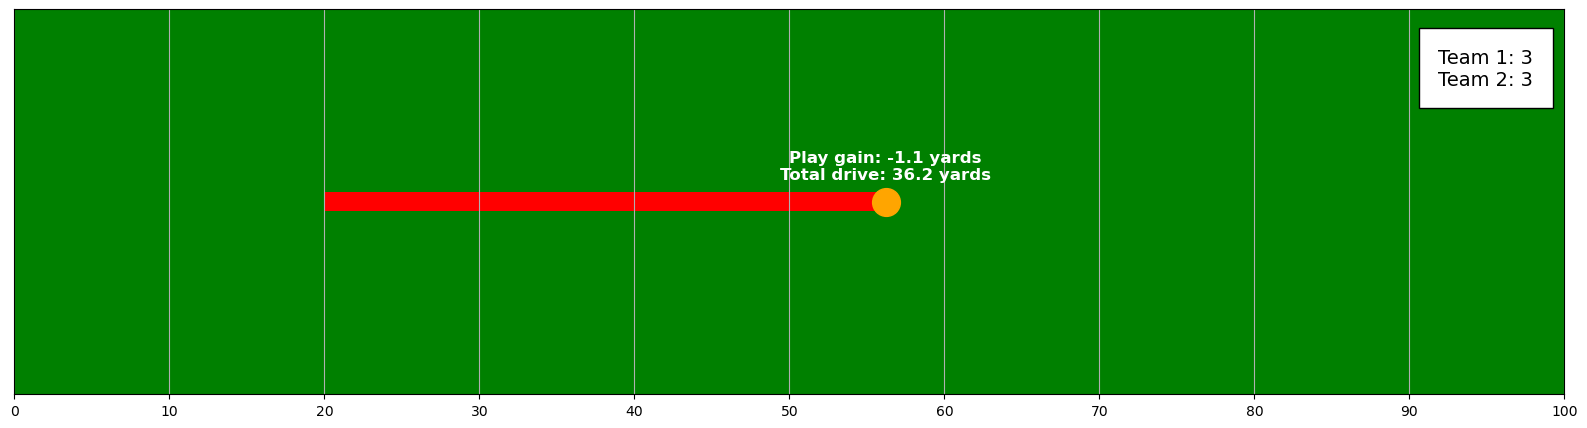

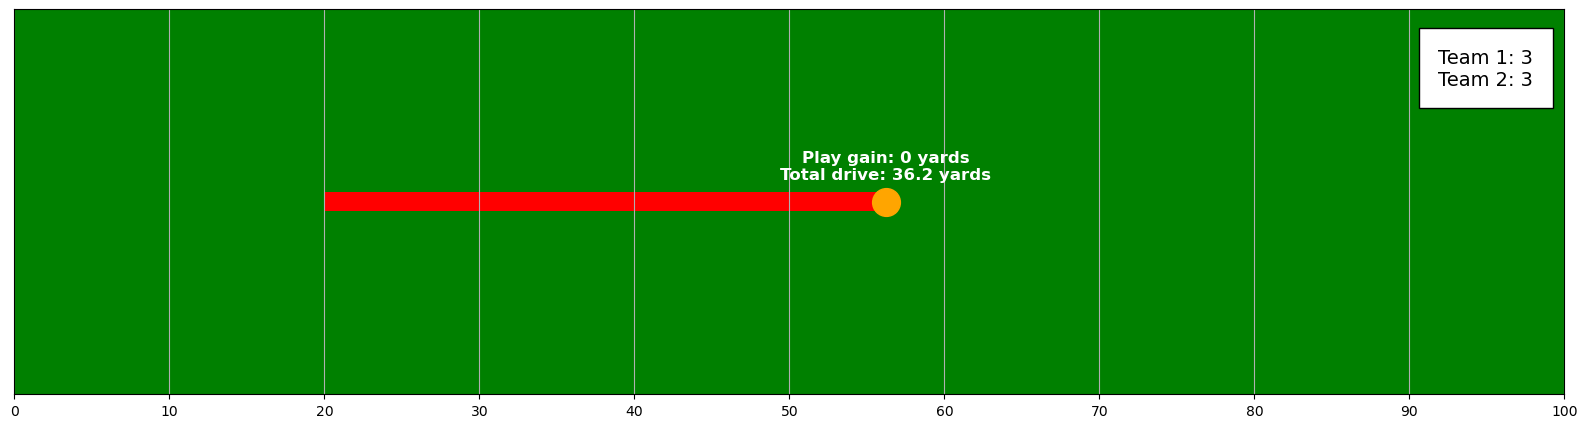

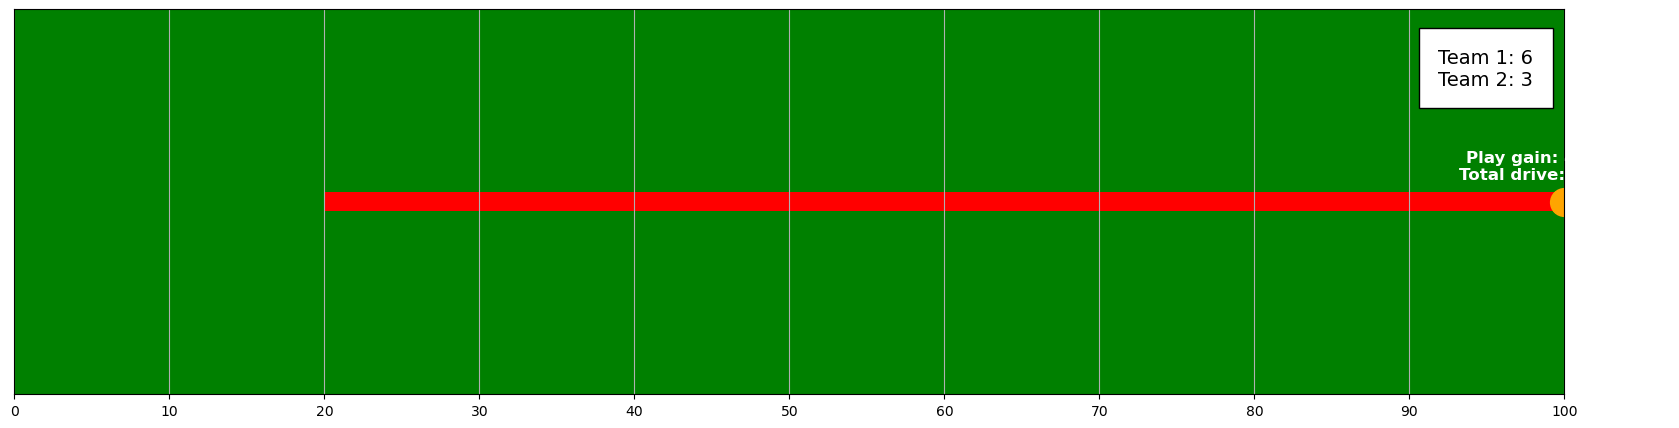

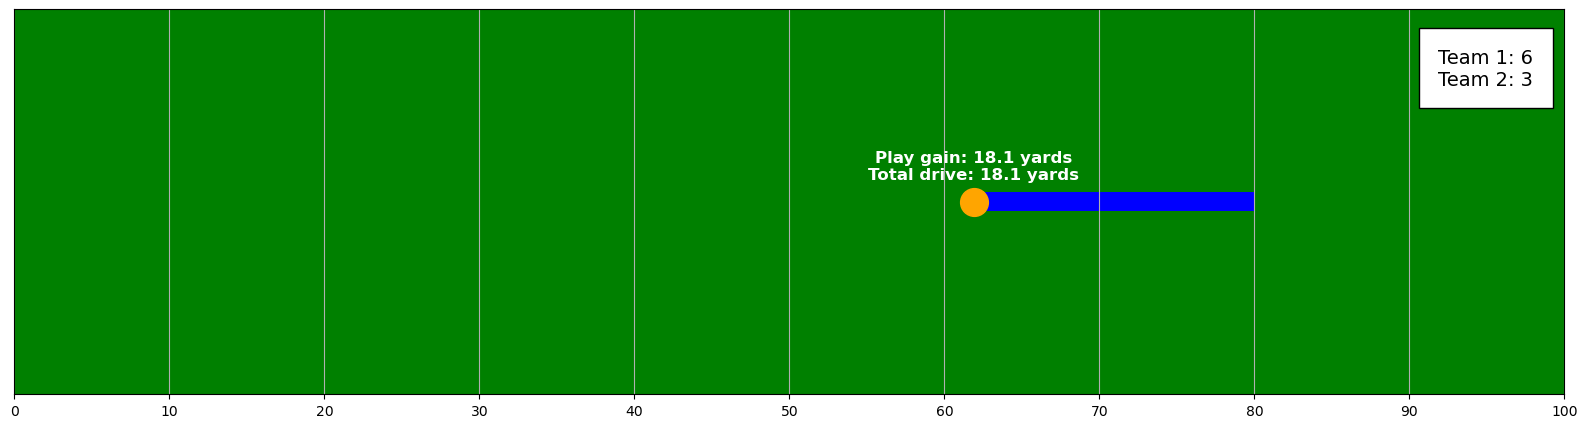

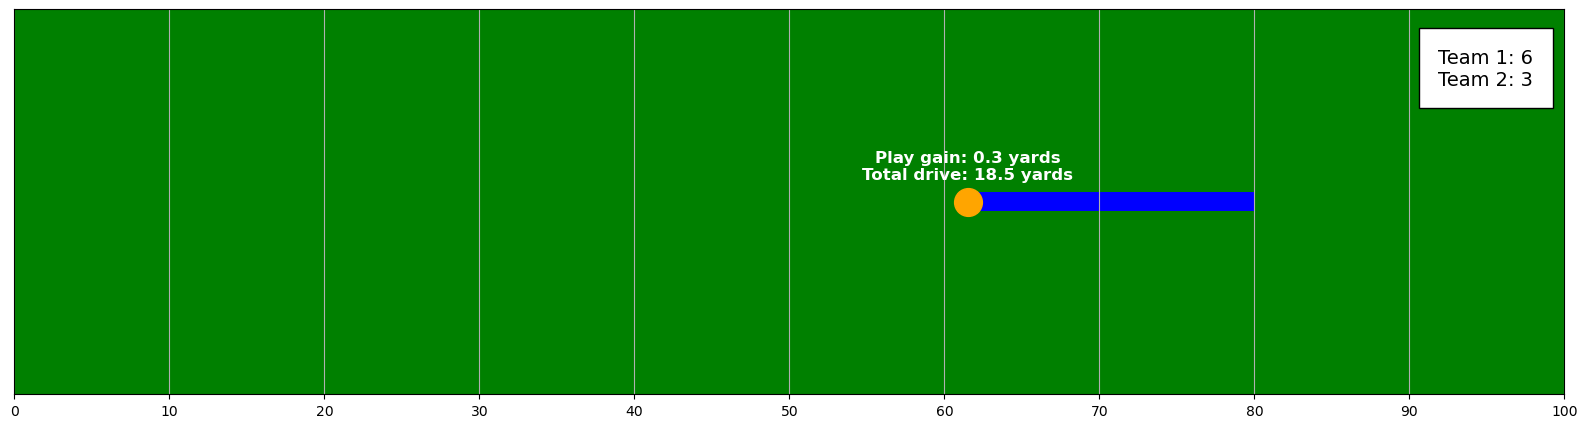

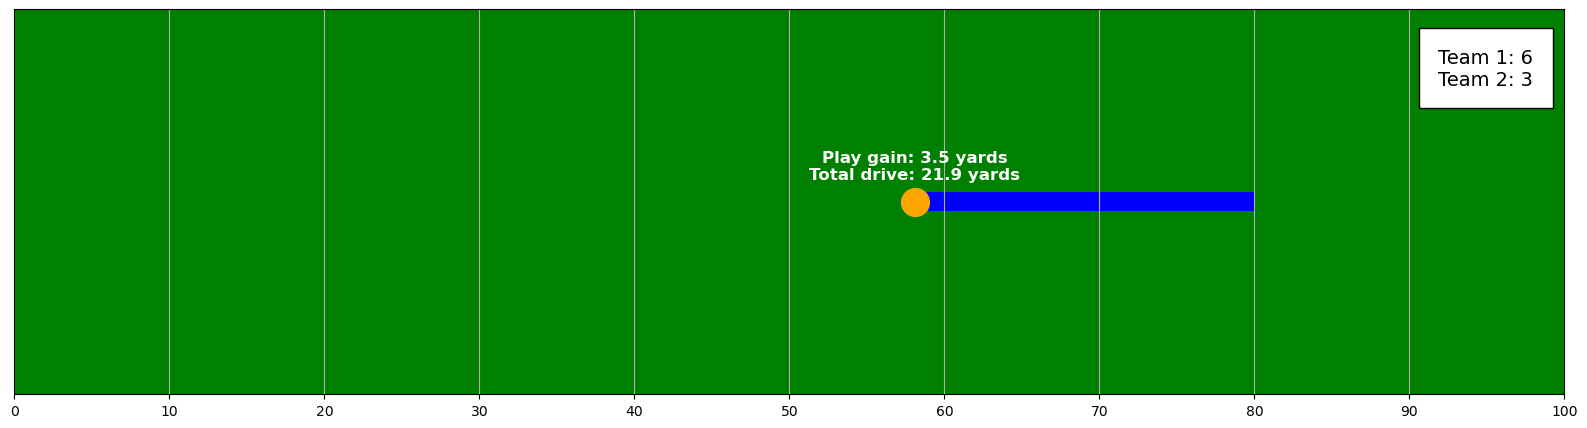

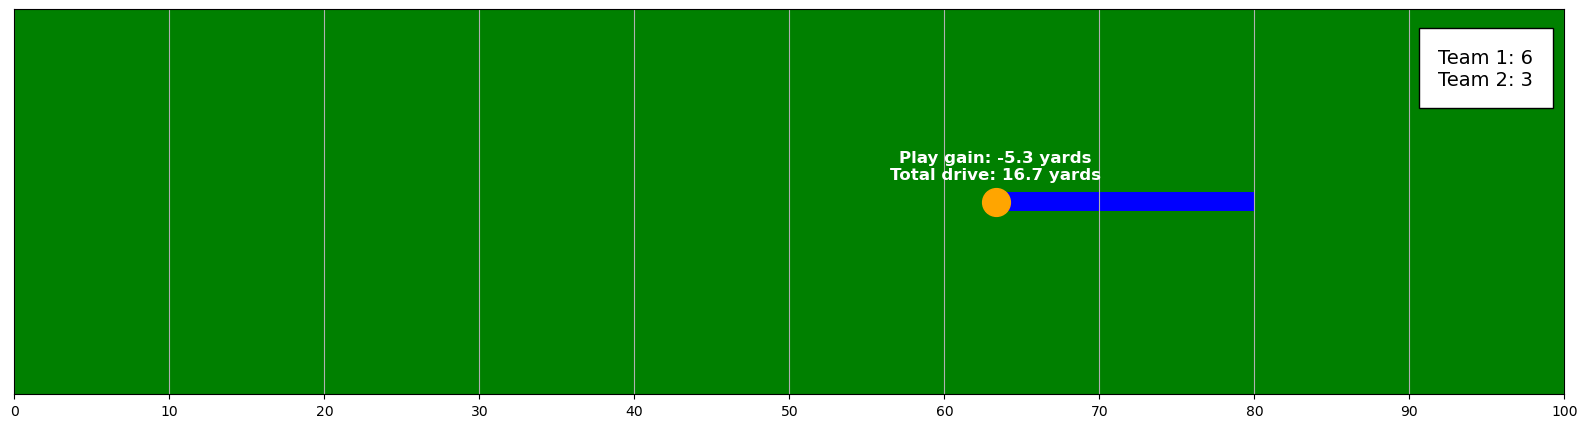

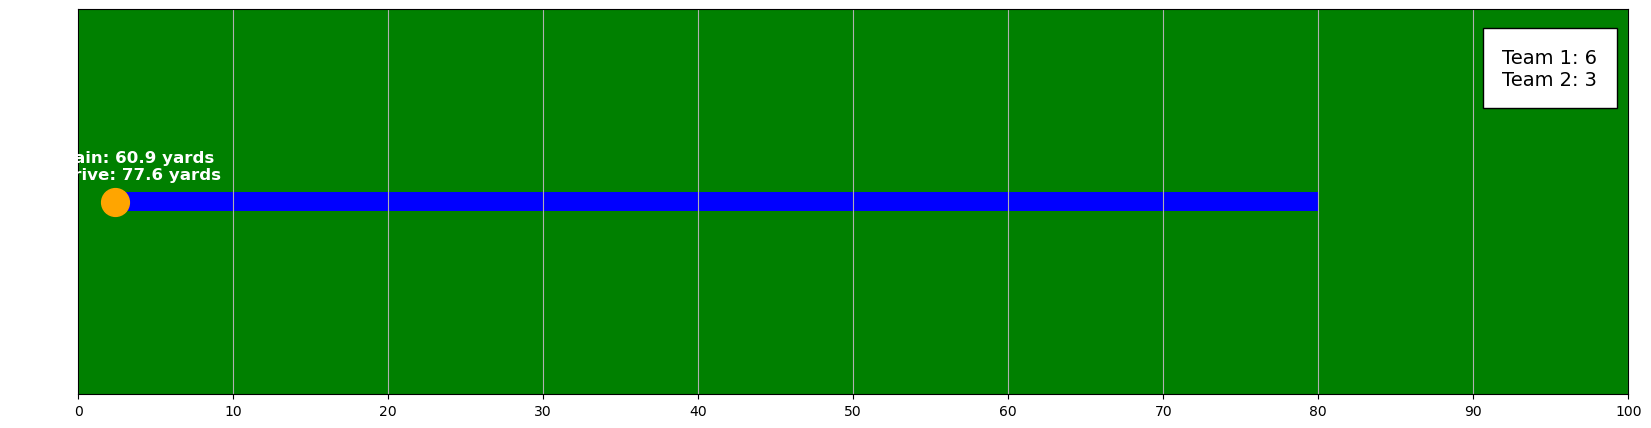

In [5]:
play_game(env=NflEnv(), text_viz='n', image_viz='y')

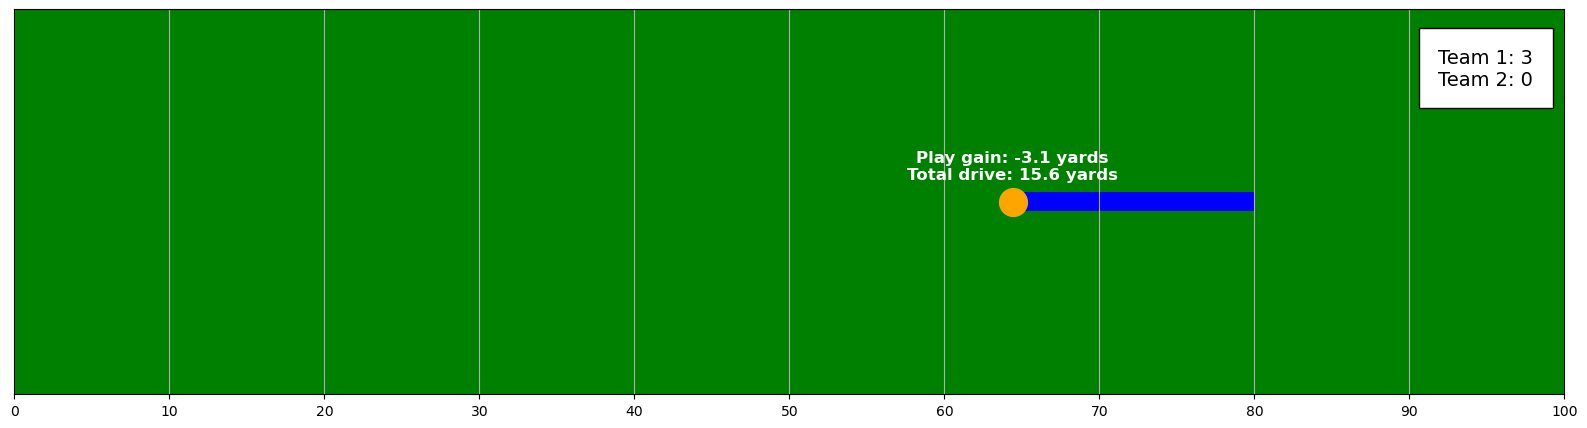

In [6]:
play_game(env=NflEnv(), text_viz='n', image_viz='y', one_image='y')

Now for the fun part, let's use RL to train agents. We'll use stable baselines3 to train and weights & biases to monitor and evaluate our training runs. First, let's import libraries and set hyperparameters.

In [7]:
import os

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy

import wandb
# https://docs.wandb.ai/guides/integrations/stable-baselines-3
from wandb.integration.sb3 import WandbCallback
wandb.login()

wandb: Currently logged in as: grantbell. Use `wandb login --relogin` to force relogin


True

In [8]:
root_dir = "C:/wand_sb3"

def create_paths(model_name, timesteps, root_dir="C:/wand_sb3"):
    # OneDrive sync error when saved in folder on desktop so ChatGPT proposed saving in C: drive
    models_dir = f"{root_dir}/models/{model_name}/"
    model_path = f"{models_dir}{timesteps}"
    logdir = f"{root_dir}/tensorboard_logs/{model_name}/"
    return models_dir, model_path, logdir

def run_training_job(model_type, timesteps=1_000_000, policy='MultiInputPolicy'
                     ,exploration_final_eps=0.025, exploration_fraction=0.5
                     , vec_envs='n', n_envs=4):
    
    timestamp = int(time.time())
    model_name = f"{timestamp}"
    models_dir, model_path, logdir = create_paths(model_name=model_name, timesteps=timesteps)

    conf_dict = {"policy": policy,
                 "model_save_name": model_name}

    run = wandb.init(
        project=f'sb3_nfl',
        dir=root_dir,
        config=conf_dict,
        sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
        save_code=True,  # optional
        name = f"{model_type}_{timesteps}_{model_name}"
    )

    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    if vec_envs == 'y':
        envs = DummyVecEnv([lambda: NflEnv() for _ in range(n_envs)])
        envs = VecNormalize(envs, norm_obs=True, norm_reward=False, norm_obs_keys=["yds_to_goal", "yds_to_first"])
        envs = VecMonitor(envs)
        env = envs
    elif vec_envs == 'n':
        env = NflEnv()
    
    if model_type == 'DQN':
        # default values for these parameters are exploration_final_eps=0.05 and exploration_fraction=0.1
        # with the default values, the exploration rate will linearly decrease to 0.05 over the first 10% of the timesteps
        model = DQN(policy, env, verbose=0, tensorboard_log=logdir, exploration_final_eps=exploration_final_eps
                    , exploration_fraction = exploration_fraction)
    elif model_type == 'PPO':
        model = PPO(policy, env, verbose=0, tensorboard_log=logdir)
    elif model_type == 'A2C':
        model = A2C(policy, env, verbose=0, tensorboard_log=logdir)

    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes)
    print(f"mean_reward before training:{mean_reward:.2f} +/- {std_reward:.2f}")

    # when using multiple environments, the total number of steps taken in counts each step taken in each environment
    # if using 4 environments and 400_000 TIMESTEPS, the agent will take a total of 100_000 steps in each environment.
    model.learn(total_timesteps=timesteps, tb_log_name=f"{model_type}")
    model.save(f"{model_path}")
    run.finish()

    parameters_saved = model.get_parameters()
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes)
    print(f"mean_reward after training:{mean_reward:.2f} +/- {std_reward:.2f}")
    
    return model

In [9]:
timesteps=500_000
dqn_model = run_training_job('DQN', timesteps=timesteps)

C:\Users\grant\anaconda3\envs\pandas_playground\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in C:/wand_sb3/tensorboard_logs/1684337894/DQN_1


mean_reward before training:-3.98 +/- 0.00


global_step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇██
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▆▅▆▇▆█▇▇▆██▇
rollout/ep_rew_mean,▁▁▁▁▂▁▁▁▁▁▂▂▂▂▂▂▃▂▂▂▂▂▃▄▄▄▅▅█▇▇▇▆▆▆▇▇▇▇▇
rollout/exploration_rate,███▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,██████▇▇▇▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▂▃▂▃▁▃▂▄▄▂▁▂▁▂▂▃▃▅▄▄▄▅▄▂▅▃▃▃▃▅▆▄▄▃▆█▆▅▅▇
global_step,499993
rollout/ep_len_mean,8.26
rollout/ep_rew_mean,3.0121
rollout/exploration_rate,0.025


mean_reward after training:3.38 +/- 5.31


In [10]:
a2c_model = run_training_job('A2C', timesteps=timesteps)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in C:/wand_sb3/tensorboard_logs/1684338562/A2C_1


mean_reward before training:-3.98 +/- 0.00


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rollout/ep_len_mean,▂▄▃▁▇▄▄▅▂▅█▅▄▆▄▂▃▄▂▄▅▇▅▂▆▅▄▄▇▅▂▅▂▃▃▃▅▄▆▃
rollout/ep_rew_mean,▂▃▄▁▅▄▅▄▁▄█▄▃▅▃▂▄▄▂▄▄▅▄▁▅▅▂▃▆▅▂▄▃▃▃▄▆▃▅▃
time/fps,█▆▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train/entropy_loss,▁█████████████▅█████████████████████████
train/explained_variance,█▅▇█████████▇█████▁▇██▆▇█▇████████▇█▃███
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/policy_loss,▁▇▇▇▇▇▇█▇▇▇▇█▇█▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train/value_loss,▂▁▁▁▁▁▂▂▂▁▁█▁▁▁▁▁▁▂▁▂▂▁▁▄▅▁▁▂▂▁▁▁▁▄▁▁▄▁▁
global_step,500000
rollout/ep_len_mean,9.74


mean_reward after training:2.34 +/- 6.08


In [11]:
ppo_model = run_training_job('PPO', timesteps=timesteps)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in C:/wand_sb3/tensorboard_logs/1684339422/PPO_1


mean_reward before training:-3.98 +/- 0.00


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rollout/ep_len_mean,▁▆▇▇▇▇▇▇▇▆▆▆▇▆▇▆▇▇▇█▇▇▇▇▇█▇███▇▆▇▇▇▇▇█▇█
rollout/ep_rew_mean,▁▅▇▆▆▇▅▆▇▄▅▅▆▆▇▅▆▆▆▇▆▇▆▇▆█▇█▇▇▇▅▇▆▇█▇▇██
time/fps,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/approx_kl,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁
train/clip_fraction,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▄▆▆▆▇▆▇▇▇▇▇████████████████████████████
train/explained_variance,▁▅▅▆▅▄▆▄▃▅▆▇▆▅▅▅█▃▅▄▆▅▄▅▅▁▅▆▄▄▇▇▄█▆▆▃▁▄▄
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▅▇▅▆▆▆█▆▇██▆▇▇▆█▆▆█▆▆█▇▆▆▆▇▇▆█▆▆▅▇▆▇▇▇█


mean_reward after training:3.39 +/- 5.89


PPO had the highest mean_reward average after training (3.73 vs 3.05 custom policy). Let's watch it play a possession against A2C, second best with 2.5 mean_reward.

In [14]:
play_game(env, model_1=a2c_model, model_2=dqn_model, possessions=3)

player 1 is an agent
player 2 is an agent

player 1 taking possession with 80.00 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Run, Yards Gained: 2.3, Turnover: False
Down: 1, Yards to First: 7.7, Yards to Goal: 77.7, Action: Run, Yards Gained: -0.2, Turnover: False
Down: 2, Yards to First: 7.9, Yards to Goal: 77.9, Action: Run, Yards Gained: 4.0, Turnover: False
Down: 3, Yards to First: 3.9, Yards to Goal: 73.9, Action: Run, Yards Gained: 12.7, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 61.1, Action: Run, Yards Gained: 2.4, Turnover: False
Down: 1, Yards to First: 7.6, Yards to Goal: 58.7, Action: Run, Yards Gained: 8.6, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 50.1, Action: Run, Yards Gained: 2.4, Turnover: False
Down: 1, Yards to First: 7.6, Yards to Goal: 47.7, Action: Run, Yards Gained: 21.6, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 26.1, Action: Run, Yards Gained: 5.2, Turnover: False
Down: 1, 

In [15]:
play_game(env, model_1=dqn_model, model_2=ppo_model, possessions=3)

player 1 is an agent
player 2 is an agent

player 1 taking possession with 80.00 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Run, Yards Gained: 16.9, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 63.1, Action: Run, Yards Gained: 12.9, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 50.2, Action: Run, Yards Gained: 9.9, Turnover: False
Down: 1, Yards to First: 0.1, Yards to Goal: 40.3, Action: Run, Yards Gained: 5.3, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 35.0, Action: Run, Yards Gained: 10.1, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 24.9, Action: Run, Yards Gained: 0.1, Turnover: False
Down: 1, Yards to First: 9.9, Yards to Goal: 24.8, Action: Run, Yards Gained: 3.3, Turnover: False
Down: 2, Yards to First: 6.6, Yards to Goal: 21.5, Action: Run, Yards Gained: -3.0, Turnover: False
Down: 3, Yards to First: 9.6, Yards to Goal: 24.5, Action: Kick, Yards Gained: 24.5, Turnover: False
Made 

let's see if vectorized environments with more steps improve performance

In [16]:
dqn_vec_model = run_training_job('DQN', timesteps=1_000_000, vec_envs='y',n_envs=4)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in C:/wand_sb3/tensorboard_logs/1684340517/DQN_1


mean_reward before training:-3.98 +/- 0.00


global_step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇██
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▃▃▂▃▄▄▄▅▆▇███▆▇▇█▆███
rollout/ep_rew_mean,▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▂▃▂▂▄▄▅▆▆▇▇▇▇▇▇▇█▇▇
rollout/exploration_rate,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,█████▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▁▁▁▁▂▂▃▃▄▄▃▄▅▅▅▇▄▆▆▆▇▆██▅█▆▆▅▆▆▅▃▅▄▅▄▅▅
global_step,999952
rollout/ep_len_mean,8.81
rollout/ep_rew_mean,3.37407
rollout/exploration_rate,0.025


mean_reward after training:3.27 +/- 5.25


In [17]:
ppo_vec_model = run_training_job('PPO', timesteps=1_000_000, vec_envs='y',n_envs=4)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in C:/wand_sb3/tensorboard_logs/1684341219/PPO_1


mean_reward before training:-0.75 +/- 0.36


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rollout/ep_len_mean,▁▃▅▆▆▆▇▇▇▇█▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▆▇█▇
rollout/ep_rew_mean,▁▄▅▆▆▆▇▆▆▇▇▇▇▆▇▆▇▇▆▇▇▇▆▇▇▇▇▇▆▇▇▇█▇█▇▆▇▇▇
time/fps,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/approx_kl,▆█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/clip_fraction,█▆▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████
train/explained_variance,▁█████▇▇█▇▇▇█▇███▇▇██▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▁▄▅▄▆▆▅█▄▆▇▆▅▇▆▇▆▆▇▇▆█▇▆█▅▄▇▇▆▇▅▇▇▆██▆▅


mean_reward after training:3.82 +/- 5.31


Mean reward for DQN was about the same but improved for PPO. Let's watch them each play a possession.

In [18]:
def pretty_print(state, action, info):
    
    down = state["down"]
    yds_to_first = state["yds_to_first"][0]
    yds_to_goal = state["yds_to_goal"][0]

    yds = info["yds"]
    turnover = info["turnover"]
    score = info["score"]
    prev_down = info["prev_down"]
    prev_yds_to_first = info["prev_yds_to_first"]
    prev_yds_to_goal = info["prev_yds_to_goal"]

    if action == 0:
        action = "Run"
    elif action == 1:
        action = "Pass"
    elif action == 2:
        action = "Kick"
    elif action == 3:
        action = "Punt"

    print(f"Down: {prev_down}, Yards to First: {prev_yds_to_first:.1f}, Yards to Goal: {prev_yds_to_goal:.1f}, Action: {action}, Yards Gained: {yds:.1f}, Turnover: {turnover}")
    if turnover: print('Turnover')
    if action == 'Kick':
        if score == 3:
            print('Made Field Goal')
        else:
            print('Missed Field Goal')
    if score == 7: print('Touchdown')


def watch_vec_episode(model):
    
    watch_n_envs = 1
    envs = DummyVecEnv([lambda: NflEnv() for _ in range(watch_n_envs)])
    envs = VecNormalize(envs, norm_obs=True, norm_reward=False, norm_obs_keys=["yds_to_goal", "yds_to_first"])
    env = VecMonitor(envs)
    
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(state)
        obs, reward, done, info = env.step(action)
        pretty_print(state, action, info[0])

In [28]:
watch_vec_episode(dqn_vec_model)

Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Run, Yards Gained: 1.0, Turnover: False
Down: 1, Yards to First: 9.0, Yards to Goal: 79.0, Action: Run, Yards Gained: 7.9, Turnover: False
Down: 2, Yards to First: 1.2, Yards to Goal: 71.2, Action: Run, Yards Gained: 6.1, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 65.1, Action: Run, Yards Gained: 6.9, Turnover: False
Down: 1, Yards to First: 3.1, Yards to Goal: 58.2, Action: Run, Yards Gained: 12.5, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 45.7, Action: Run, Yards Gained: 2.1, Turnover: False
Down: 1, Yards to First: 7.9, Yards to Goal: 43.6, Action: Run, Yards Gained: 4.6, Turnover: False
Down: 2, Yards to First: 3.3, Yards to Goal: 39.0, Action: Run, Yards Gained: 0.4, Turnover: False
Down: 3, Yards to First: 2.9, Yards to Goal: 38.6, Action: Run, Yards Gained: 6.9, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 31.7, Action: Run, Yards Gained: 3.6, Turnover: False
Down:

In [45]:
watch_vec_episode(ppo_vec_model)

Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Run, Yards Gained: 6.6, Turnover: False
Down: 1, Yards to First: 3.4, Yards to Goal: 73.4, Action: Run, Yards Gained: 5.1, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 68.4, Action: Run, Yards Gained: 4.4, Turnover: False
Down: 1, Yards to First: 5.6, Yards to Goal: 64.0, Action: Run, Yards Gained: 6.2, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 57.8, Action: Run, Yards Gained: -2.3, Turnover: False
Down: 1, Yards to First: 12.3, Yards to Goal: 60.1, Action: Run, Yards Gained: 4.7, Turnover: False
Down: 2, Yards to First: 7.6, Yards to Goal: 55.4, Action: Run, Yards Gained: 5.8, Turnover: False
Down: 3, Yards to First: 1.8, Yards to Goal: 49.6, Action: Run, Yards Gained: 11.7, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 37.9, Action: Run, Yards Gained: 14.1, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 23.8, Action: Run, Yards Gained: 1.4, Turnover: False
D


Example of loading and continued training below


In [ ]:
del model  # delete trained model to demonstrate loading

if model_type == 'DQN':
    if os.path.exists(models_dir):
        model = DQN.load(model_path, env=envs, tensorboard_log=logdir)
    else:
        model = DQN(policy, envs, verbose=0, tensorboard_log=logdir, exploration_final_eps=0.025, exploration_fraction=0.01)
elif model_type == 'PPO':
    if os.path.exists(models_dir):
        model = PPO.load(model_path, env=envs, tensorboard_log=logdir)
    else:
        model = PPO(policy, envs, verbose=0, tensorboard_log=logdir)
elif model_type == 'A2C':
    if os.path.exists(models_dir):
        model = A2C.load(model_path, env=envs, tensorboard_log=logdir)
    else:
        model = A2C(policy, envs, verbose=0, tensorboard_log=logdir)

mean_reward, std_reward = evaluate_policy(model, envs, n_eval_episodes=n_eval_episodes)
print(f"mean_reward after load:{mean_reward:.2f} +/- {std_reward:.2f}")
parameters_loaded = model.get_parameters()

mean_reward test suggests load was successful but let's check the model weights to be sure

In [ ]:
def compare_dicts(dict1, dict2):
    # Compare two dictionaries
    for key in dict1:
        if key not in dict2:
            return False

        if isinstance(dict1[key], torch.Tensor):
            if not torch.all(torch.eq(dict1[key], dict2[key])):
                return False
        elif isinstance(dict1[key], dict):
            if not compare_dicts(dict1[key], dict2[key]):
                return False
        elif dict1[key] != dict2[key]:
            return False

    return True

print(compare_dicts(parameters_saved, parameters_loaded))

# # uncomment below if you want to check visually
# print('parameters saved')
# print(parameters_saved)
# print('parameters loaded')
# print(parameters_loaded)

In [ ]:
incremental_TIMESTEPS = 100_000

# Start a new wandb run
run = wandb.init(
    project=f'sb3_nfl',
    config=conf_dict,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    save_code=True,  # optional
    name = f"{model_type}_{TIMESTEPS}_{model_name}_incremental_{incremental_TIMESTEPS}"
)

# Continue training the model
model.learn(total_timesteps=incremental_TIMESTEPS, tb_log_name=f"{model_type}_{incremental_TIMESTEPS}")
model.save(f"{model_path}_incremental_{incremental_TIMESTEPS}")

mean_reward, std_reward = evaluate_policy(model, envs, n_eval_episodes=n_eval_episodes)
print(f"mean_reward after incremental training:{mean_reward:.2f} +/- {std_reward:.2f}")

# Finish the wandb run
run.finish()